# Проект

# Металлургическое предприятие

**Цель проекта:**

Оптимизировать производственные расходы, уменьшив потребление электроэнергии на этапе обработки стали.

## Описание проекта

**Импорт библиотек.**

**Загрузка данных**

Данные загружены и обработаны:

* выведены первые строки таблиц, информация о файлах
* названия колонок приведены к змеиному регистру, переведены на латиницу
* даты приведены к типу datetime

**Исследовательский анализ и предобработка данных**

Проведен исследовательский анализ исходных данных:

* выведено описание признаков
* выявлена аномалия в реактивной мощности (высокое отрицательное значение)
  аномалия заменена на долю активной мощности в среднем по данной плавке
* полных дубликатов не обнаружено
* выявлено большое число пропусков (в дальнейшем заменены на нули):
  - в показателях температуры
  - в объемах и времени добавления лигирующих добавок
  - определены показатели с числом пропусков больше 80% (9 видов сыпучих материалов и 7 видов проволочных)
* рассмотрены графики распределения признаков: гистограммы и бокс-плоты
  - признаки не имют нормального распределения
  - в признаках есть выбросы (технологические особенности)
* удалены значения температуры ниже 1500 градусов (согласно технологическому процессу) и пропуски (т.к. это целевой признак)
* удалены плавки с единичным показателем температуры (740 плавок, все номера от 2500 и отдельные плавки с меньшшими номерами)
* определены виды лигирующих добавок, применяемых менее чем в 10% плавок.
* выявлены 2 вида лигирующих добавок, применявшихся единожды, определены номера плавок (к удалению)

**Объединение данных**

* данные объеденены в единый файл (методом INNER)
* предварительно созданы вспомогательные таблицы с группировкой по ключу и признаками: 
  - общая мощность
  - время нагрева
  - число итераций нагрева
  - первая температура
  - последняя температура
  - суммарный объем лигирующих добавок (по видам)
* удалены плавки с единичным использованием лигирующих добавок bulk_8, wire_5
* удалены ключи (номера плавок)
* выведено описание итогового файла

**Исследовательский анализ и предобработка данных объединённого датафрейма**

Проведен исследовательский анализ итогового файла:

* выведены информация о файле и описание признаков
* полных дубликатов не обнаружено
* добавлены новые признаки:
  - работа
  - интервал между замерами первой и последней температур
* рассмотрены гистограммы распределения признаков: выбросы сохранены (особенности технологического процесса) 
* проведены тесты Шапиро-Уилка и Д'Агостино на нормальность распределения:
  - признаки не имют нормального распределения
* прведен корреляционный анализ признаков: Спирмана и Фи
  - удалена мультиколлинеарность
  - исключены признаки активной и реактивной мощности, добавки 'wire_8', 'wire_7', 'wire_4'

**Подготовка данных**

* определены целевой признак и входящие
* данные разбиты на тренировочную и тестовую выборки
* создан пайплайн для работы модели

**Обучение моделей**

Обучение моделей проведено с использованием пайплайна и оценки метрики при кросс-валидации.

Обучены модели (в т.ч. с подбором гиперпараметров):
* DummyRegressor
* LinearRegression
* DecisionTreeRegressor
* ElasticNet
* RandomForestRegressor
* CatBoostRegressor
* LGBMRegressor
* HistGradientBoostingRegressor

Рассчитана метрика MAE

**Выбор лучшей модели**

Определена лучшая модель по минимальной метрике MAE на тестовой выборке.

Рассчитаны для тестовой выборки метрики MAE, R2.

**Анализ важности признаков**

Проведен анализ важности признаков лучшей модели.

Определены ключевые признаки.

Обучена модель на группе признаков после удаления наименее значимых: метрика MAE улучшилась.

**Общий вывод и рекомендации заказчику**

## Импорт библиотек

In [1]:
!pip install phik -q
!pip install shap -q
#!pip install optuna -q
!pip install mlxtend -q
!pip install imbalanced-learn -q

In [2]:
import os
import math
import phik
import shap
import random
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as st
import plotly.express as px
import statsmodels.api as sm
import matplotlib.colors as colors

In [3]:
import datetime

In [4]:
from statsmodels.graphics.gofplots import qqplot
#from sklearn.feature_selection import f_classif, mutual_info_classif
#from imblearn.over_sampling import RandomOverSampler, SMOTE, SMOTENC, ADASYN
from sklearn.linear_model import LogisticRegression, LinearRegression
#from optuna.integration import OptunaSearchCV
#from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, confusion_matrix, r2_score, precision_score, recall_score, 
                             roc_auc_score, f1_score, make_scorer, mean_squared_error, mean_absolute_error)
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.svm import SVC
from matplotlib import pyplot as plt
#from optuna import distributions, visualization
#from imblearn import under_sampling, over_sampling
from scipy.stats import lognorm, shapiro, normaltest, anderson, uniform, pearsonr
from phik.report import plot_correlation_matrix
#from sklearn.dummy import DummyClassifier
from sklearn.compose import ColumnTransformer
#from sklearn.datasets import make_classification
#from sklearn.multiclass import OneVsRestClassifier
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import (OneHotEncoder, OrdinalEncoder, LabelEncoder,
                                   StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, PolynomialFeatures)
#from scipy.spatial.distance import (cosine, euclidean)
from sklearn.model_selection import (train_test_split, KFold, StratifiedKFold, cross_val_score,
                                     GridSearchCV, RandomizedSearchCV)
from sklearn.linear_model import ElasticNet, Lasso, Ridge
from catboost import CatBoostClassifier, CatBoostRegressor
from catboost import Pool, cv
from lightgbm import LGBMRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.dummy import DummyRegressor

In [5]:
#from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_selection import SelectKBest
#from imblearn.under_sampling import RandomUnderSampler
#from sklearn.linear_model import LassoCV
#from sklearn.ensemble import RandomForestClassifier
#from imblearn.combine import SMOTETomek
from mlxtend.plotting import plot_decision_regions
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeRegressor
from itertools import combinations
from sklearn import tree
from phik import phik_matrix
from math import sqrt

In [6]:
# Зададим отображение всех колонок

pd.set_option("display.max.columns", None)

In [7]:
# Зададим отображение 3-х десятичных знаков

pd.options.display.float_format = '{:.3f}'.format

In [8]:
# Определим random_state и test_size

RANDOM_STATE = 200524
TEST_SIZE = 0.25

## Загрузка данных

In [9]:
data_arc_new = pd.read_csv(# ссылка на файл)

In [10]:
data_bulk_new = pd.read_csv(# ссылка на файл)

In [11]:
data_bulk_time_new = pd.read_csv(# ссылка на файл)

In [12]:
data_gas_new = pd.read_csv(# ссылка на файл)

In [13]:
data_temp_new = pd.read_csv(# ссылка на файл)

In [14]:
data_wire_new = pd.read_csv(# ссылка на файл)

In [15]:
data_wire_time_new = pd.read_csv(# ссылка на файл)

In [16]:
# Создадим список с названиями файлов

df_name_list = ['data_arc_new', 'data_bulk_new', 'data_bulk_time_new', 'data_gas_new',
           'data_temp_new', 'data_wire_new', 'data_wire_time_new']

In [17]:
# Создадим список файлов

df_list = [data_arc_new, data_bulk_new, data_bulk_time_new, data_gas_new,
           data_temp_new, data_wire_new, data_wire_time_new]

In [18]:
# Выведем первые 5 строк каждого файла и информацию о файле

for i, item in enumerate(df_name_list):
    print(df_name_list[i], '\n')
    print(df_list[i].head(), '\n')
    print(df_list[i].info(), '\n')
    

data_arc_new 

   key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
0    1  2019-05-03 11:02:14  2019-05-03 11:06:02              0.305   
1    1  2019-05-03 11:07:28  2019-05-03 11:10:33              0.766   
2    1  2019-05-03 11:11:44  2019-05-03 11:14:36              0.580   
3    1  2019-05-03 11:18:14  2019-05-03 11:24:19              0.518   
4    1  2019-05-03 11:26:09  2019-05-03 11:28:37              0.867   

   Реактивная мощность  
0                0.211  
1                0.477  
2                0.430  
3                0.380  
4                0.644   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  

Названия колонок стоит привести к единому формату.
Типы данных: к формату DateTime (в соотв. колонках)

В данных об электродах и о продувке сплава газом нет пропусков.

В данных о результатах измерения температуры есть пропуски в показателях температуры. Это важная информация. Далее рассмотрим этот момент более деательно, можно ли заполнить пропуски или придется удалять эти данные.

В остальных файлах также есть пропуски, но это скорее технологические особенности (если в ходе дальнейшего исследования не выяснится иное).

Стоит отметить, что некоторые показатели сыпучих материалов и проволки имеют лишь одно ненулевое значение, или крайне незначительное количество ненулвеых значений. Возможно, это не самые важные признаки. вернемся к этому позже

### Предварительные преобразования

Преобразуем названия колонок: приведем их к "Змеиному регистру".

In [19]:
# Выведем названия колонок каждого файла

for i, item in enumerate(df_list):
    print(df_name_list[i], '\n')
    print(df_list[i].columns, '\n')

data_arc_new 

Index(['key', 'Начало нагрева дугой', 'Конец нагрева дугой',
       'Активная мощность', 'Реактивная мощность'],
      dtype='object') 

data_bulk_new 

Index(['key', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6',
       'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12',
       'Bulk 13', 'Bulk 14', 'Bulk 15'],
      dtype='object') 

data_bulk_time_new 

Index(['key', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6',
       'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12',
       'Bulk 13', 'Bulk 14', 'Bulk 15'],
      dtype='object') 

data_gas_new 

Index(['key', 'Газ 1'], dtype='object') 

data_temp_new 

Index(['key', 'Время замера', 'Температура'], dtype='object') 

data_wire_new 

Index(['key', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6',
       'Wire 7', 'Wire 8', 'Wire 9'],
      dtype='object') 

data_wire_time_new 

Index(['key', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6',
       'W

Переименуем колонки в файлах

In [20]:
data_arc_new.columns = ['key', 'start_arc_heating', 'end_arc_heating',
       'active_power', 'reactive_power']

In [21]:
data_bulk_new.columns = ['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8', 
                          'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15']

In [22]:
data_bulk_time_new.columns = ['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8', 
                               'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15']

In [23]:
data_gas_new.columns = ['key', 'gas_1']

In [24]:
data_temp_new.columns = ['key', 'measure_time', 'temperature']

In [25]:
data_wire_new.columns = ['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9']

In [26]:
data_wire_time_new.columns = ['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9']

Преобразуем даты в соотв. формат

In [27]:
data_arc_new[['start_arc_heating', 'end_arc_heating']] = \
data_arc_new[['start_arc_heating', 'end_arc_heating']].apply(pd.to_datetime)

In [28]:
data_bulk_time_new[['bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10',
                    'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15']] = \
data_bulk_time_new[['bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10',
                    'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15']].apply(pd.to_datetime)

In [29]:
data_temp_new['measure_time'] = pd.to_datetime(data_temp_new['measure_time'])

In [30]:
data_wire_time_new[['wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5',
                    'wire_6', 'wire_7', 'wire_8', 'wire_9']] = \
data_wire_time_new[['wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5',
                    'wire_6', 'wire_7', 'wire_8', 'wire_9']].apply(pd.to_datetime)

Проверим результат

In [31]:
df_list_2 = [data_arc_new, data_bulk_time_new, data_temp_new, data_wire_time_new]

In [32]:

for i, item in enumerate(df_list_2):
    print(df_list_2[i].info(), '\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   key                14876 non-null  int64         
 1   start_arc_heating  14876 non-null  datetime64[ns]
 2   end_arc_heating    14876 non-null  datetime64[ns]
 3   active_power       14876 non-null  float64       
 4   reactive_power     14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   bulk_1   252 non-null    datetime64[ns]
 2   bulk_2   22 non-null     datetime64[ns]
 3   bulk_3   1298 non-null   datetime64[ns]
 4   bulk_4   1014 non-null   datetime64[ns]
 5   bu

**Вывод:**

Данные загружены, проведена предварительная обработка: переименованы колонки, изменены типы данных

## Исследовательский анализ и предобработка данных

In [33]:
# Выведем описания данных каждого файла

for i, item in enumerate(df_name_list):
    print(df_name_list[i], '\n')
    print(df_list[i].describe(), '\n')
    

data_arc_new 

            key  active_power  reactive_power
count 14876.000     14876.000       14876.000
mean   1615.220         0.663           0.439
std     934.572         0.259           5.873
min       1.000         0.223        -715.480
25%     806.000         0.467           0.337
50%    1617.000         0.600           0.442
75%    2429.000         0.830           0.608
max    3241.000         1.464           1.270 

data_bulk_new 

           key  bulk_1  bulk_2   bulk_3   bulk_4  bulk_5  bulk_6  bulk_7  \
count 3129.000 252.000  22.000 1298.000 1014.000  77.000 576.000  25.000   
mean  1624.384  39.242 253.045  113.879  104.394 107.026 118.925 305.600   
std    933.338  18.278  21.181   75.483   48.184  81.791  72.058 191.023   
min      1.000  10.000 228.000    6.000   12.000  11.000  17.000  47.000   
25%    816.000  27.000 242.000   58.000   72.000  70.000  69.750 155.000   
50%   1622.000  31.000 251.500   97.500  102.000  86.000 100.000 298.000   
75%   2431.000  46.00

In [34]:
data_bulk_time_new.drop('key', axis=1).describe(datetime_is_numeric=True)

,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
count,252,22,1298,1014,77,576,25,1,19,176,177,2450,18,2806,2248
mean,2019-06-29 23:24:44.769841152,2019-07-12 07:57:13.045454592,2019-07-08 13:50:14.630970624,2019-07-03 11:17:28.834319616,2019-07-13 17:18:29.090908928,2019-07-06 13:50:06.345486080,2019-07-27 18:09:05.079999744,2019-07-08 17:14:53,2019-06-23 08:08:47.578947328,2019-07-06 23:55:10.954545408,2019-07-15 07:01:00.615819264,2019-07-05 22:55:11.468571392,2019-07-01 18:32:46.944444416,2019-07-06 07:17:48.372772608,2019-07-06 13:24:51.912366336
min,2019-05-03 17:42:46,2019-05-07 15:39:35,2019-05-03 20:40:25,2019-05-03 11:28:48,2019-05-07 15:19:17,2019-05-03 19:09:15,2019-05-07 18:11:01,2019-07-08 17:14:53,2019-05-14 11:57:58,2019-05-06 07:54:02,2019-05-05 23:43:24,2019-05-03 11:24:31,2019-05-05 02:10:21,2019-05-03 11:14:50,2019-05-03 11:10:43
25%,2019-05-29 14:48:48.500000,2019-05-28 02:29:31.500000,2019-06-08 03:50:23.500000,2019-05-30 21:36:11.249999872,2019-06-19 23:32:44,2019-06-06 22:46:10.500000,2019-07-20 23:48:47,2019-07-08 17:14:53,2019-05-14 14:31:08,2019-06-02 05:12:00.500000,2019-06-14 20:24:48,2019-06-03 12:48:47.249999872,2019-05-29 10:43:31.249999872,2019-06-04 04:50:42,2019-06-04 11:28:18
50%,2019-06-25 11:09:13,2019-07-27 17:18:38.500000,2019-07-04 09:31:42,2019-06-28 03:44:42.500000,2019-07-25 17:59:41,2019-07-09 03:34:57.500000,2019-07-27 18:07:02,2019-07-08 17:14:53,2019-05-14 16:55:09,2019-07-06 07:05:20,2019-07-24 11:17:22,2019-07-03 01:32:00,2019-07-01 12:59:36.500000,2019-07-03 21:54:13.500000,2019-07-03 16:43:28.500000
75%,2019-07-31 05:58:18.249999872,2019-08-13 02:20:08,2019-08-11 01:00:36.750000128,2019-08-04 04:15:46.500000,2019-08-13 04:23:23,2019-08-07 18:55:01.249999872,2019-08-13 04:19:43,2019-07-08 17:14:53,2019-08-16 05:43:31,2019-08-04 02:23:35.750000128,2019-08-11 05:21:01,2019-08-08 14:55:05.249999872,2019-08-04 23:32:00.249999872,2019-08-09 04:22:40.500000,2019-08-09 09:18:31.750000128
max,2019-09-05 09:11:32,2019-08-13 11:47:39,2019-09-06 12:26:52,2019-09-05 03:35:21,2019-09-02 18:16:52,2019-09-06 16:24:28,2019-09-05 19:07:49,2019-07-08 17:14:53,2019-08-16 09:11:56,2019-09-04 10:03:22,2019-09-06 05:03:14,2019-09-06 15:01:44,2019-09-01 01:53:02,2019-09-06 17:26:33,2019-09-06 17:23:15


In [35]:
data_wire_time_new.drop('key', axis=1).describe(datetime_is_numeric=True)

,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
count,3055,1079,63,14,1,73,11,19,29
mean,2019-07-05 23:22:34.279541760,2019-07-07 01:07:08.735866624,2019-07-10 15:09:58.650793472,2019-07-11 13:44:37,2019-08-13 06:14:30,2019-07-07 11:51:15.095890432,2019-08-07 01:16:08.090909184,2019-06-23 07:47:49.052631552,2019-07-01 11:56:04.793103616
min,2019-05-03 11:06:19,2019-05-03 13:15:34,2019-05-04 04:34:27,2019-05-07 15:19:17,2019-08-13 06:14:30,2019-05-07 14:46:05,2019-07-27 05:49:05,2019-05-14 11:29:24,2019-05-04 17:21:27
25%,2019-06-04 19:30:11.500000,2019-06-05 14:50:26.500000,2019-06-11 14:17:38.500000,2019-07-20 17:58:53.750000128,2019-08-13 06:14:30,2019-05-08 21:47:30,2019-07-27 16:27:27,2019-05-14 14:20:07.500000,2019-06-09 19:36:17
50%,2019-07-03 06:36:23,2019-07-04 23:13:39,2019-07-21 10:04:47,2019-07-27 05:45:26.500000,2019-08-13 06:14:30,2019-07-28 05:00:32,2019-08-12 21:48:11,2019-05-14 16:55:09,2019-06-11 10:10:21
75%,2019-08-08 08:56:06.500000,2019-08-08 23:15:17,2019-08-12 22:54:46,2019-07-27 16:20:04.750000128,2019-08-13 06:14:30,2019-08-13 13:33:02,2019-08-13 02:02:55.500000,2019-08-16 05:06:53.500000,2019-08-09 06:49:04
max,2019-09-06 17:10:06,2019-09-06 07:35:40,2019-09-02 07:14:44,2019-08-13 03:16:45,2019-08-13 06:14:30,2019-08-18 19:10:56,2019-08-13 10:25:22,2019-08-16 08:56:23,2019-09-03 12:55:23


Всего получается 3 241 номера плавки (по ключу) (Не количество, а именно номера).

В файле data_arc_new (информация об электродах):
* Активная мощность возрастает равномерно примерно на 0,2 до 75%-го показателя, а макисмальная мощность увеличивается почти в 2 раза от 75%-го значения.
* Реактивная мощность показывает явную ошибку в минимальной точке = -715.480. В максимальном значении также существенный скачок мощности по сравнению с 75%-м значением.

В файле data_bulk_new (данные о подаче сыпучих материалов(объем)) при предварительном просмотре в основной части данных не заметно аномальных значений.

В файлах data_gas_new и data_temp_new предварительно не заметно аномальных значений, данные распределены по квартилям довольно равномерно.

Аналогичная ситуация с файлом data_wire_new.

In [36]:
# Проверим наличие полных дубликатов

print(f'Количество полных дубликатов в файле:')
for df in df_list:
    df_name = [x for x in globals() if globals()[x] is df][0]
    print(f'- {df_name}: {df.duplicated().sum()}')

Количество полных дубликатов в файле:
- data_arc_new: 0
- data_bulk_new: 0
- data_bulk_time_new: 0
- data_gas_new: 0
- data_temp_new: 0
- data_wire_new: 0
- data_wire_time_new: 0


Полных дубликатов нет.

Проверим пропуски в данных

In [37]:
# Проверим пропуски в данных

print(f'Количество пропусков в файле:')
for i, df in enumerate(df_list):
    print(f'- {df_name_list[i]}: {df.isna().sum().to_frame()}')
    print(f'Размер файла: {df.shape}','\n')


Количество пропусков в файле:
- data_arc_new:                    0
key                0
start_arc_heating  0
end_arc_heating    0
active_power       0
reactive_power     0
Размер файла: (14876, 5) 

- data_bulk_new:             0
key         0
bulk_1   2877
bulk_2   3107
bulk_3   1831
bulk_4   2115
bulk_5   3052
bulk_6   2553
bulk_7   3104
bulk_8   3128
bulk_9   3110
bulk_10  2953
bulk_11  2952
bulk_12   679
bulk_13  3111
bulk_14   323
bulk_15   881
Размер файла: (3129, 16) 

- data_bulk_time_new:             0
key         0
bulk_1   2877
bulk_2   3107
bulk_3   1831
bulk_4   2115
bulk_5   3052
bulk_6   2553
bulk_7   3104
bulk_8   3128
bulk_9   3110
bulk_10  2953
bulk_11  2952
bulk_12   679
bulk_13  3111
bulk_14   323
bulk_15   881
Размер файла: (3129, 16) 

- data_gas_new:        0
key    0
gas_1  0
Размер файла: (3239, 2) 

- data_temp_new:                  0
key              0
measure_time     0
temperature   3427
Размер файла: (18092, 3) 

- data_wire_new:            0
key        0


In [38]:
# Создадим функцию для отображения доли пропусков

def empty_spaces(df, name):
    
    df_new = (df.isna().mean()*100).to_frame().rename(columns={0:'space'}).query('space > 0').sort_values(
        by='space', ascending=True)
    
    limit = 80
    highlight_colour = '#d95f02'
    non_highlight_colour = 'SteelBlue'
    
    df_new['colours'] = df_new.space.apply(lambda x: highlight_colour if x < limit else non_highlight_colour)
    
    df_new = df_new.sort_values(by='space')
    
    fig, ax = plt.subplots(figsize=(12,5))
    
    bars = plt.barh(df_new.index, df_new.space, height=0.7, color=df_new['colours'])
    
    ax.yaxis.set_tick_params(labelsize=12)
    ax.axvline(x=80, zorder=0, color='red', ls='--', lw=1.5)
    ax.text(x=80, y=1, s='80%', ha='center', 
            fontsize=12, bbox=dict(facecolor='white', edgecolor='red', ls='--'))
    
    ax.set_title(f'{name} Empty Spaces > 80%', fontsize=12, pad=20)
    
    plt.show();

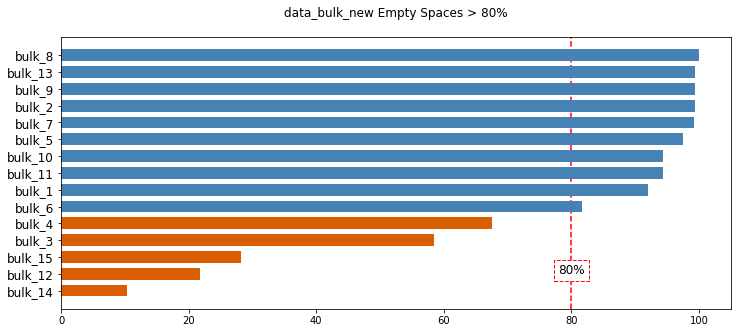

In [39]:
empty_spaces(data_bulk_new, 'data_bulk_new')

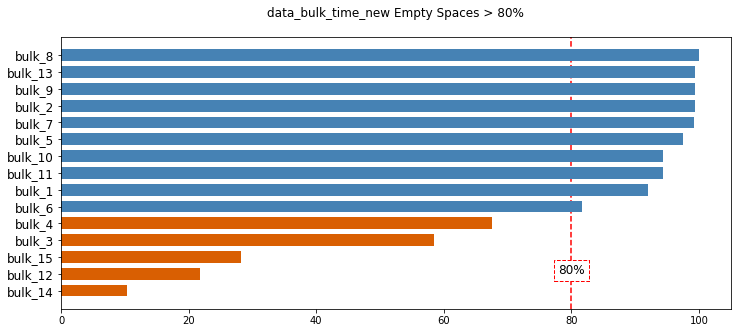

In [40]:
empty_spaces(data_bulk_time_new, 'data_bulk_time_new')

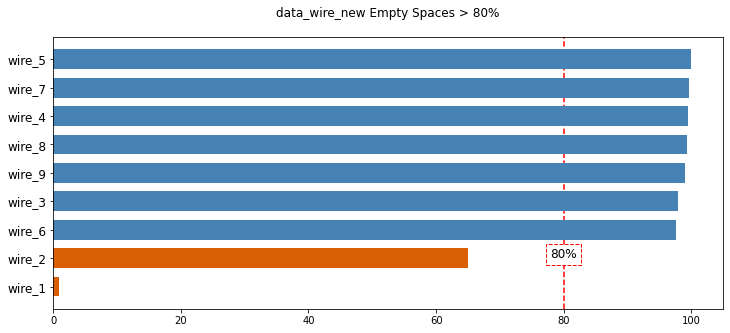

In [41]:
empty_spaces(data_wire_new, 'data_wire_new')

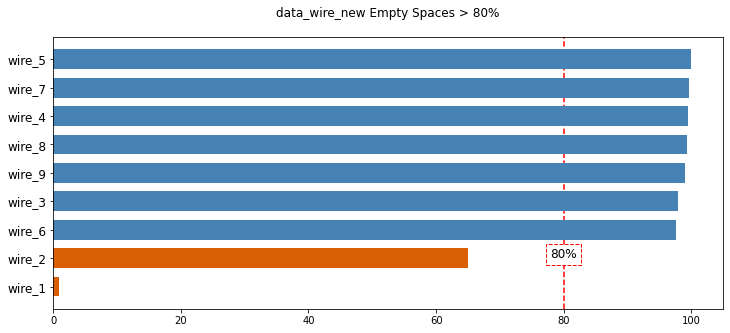

In [42]:
empty_spaces(data_wire_time_new, 'data_wire_new')

В данных об электродах и продувке газом пропусков нет.

В файле с температурой 3 427 пропусков.

В данных о сыпучих материалах и проволке пропуски совпадают в показателях объема и времени, т.е. это именно добавление отдельных видов сыпучих материалов и проволоки, они отличаются для разных партий металла.

Поскольку это технологические процессы, стоит заменить пропуски на ноль в файлах о сыпучих материалах и проволке.

Однако, эту манипуляцию мы проведем после рассмотрения графиков распределения, иначе нули будут забирать слишком много внимания.

Рассмотрим значения температур

In [43]:
data_temp_new.temperature.value_counts().to_frame().sort_index(ascending=True).T

,1191.000,1204.000,1208.000,1218.000,1227.000,1515.000,1519.000,1520.000,1521.000,1522.000,1525.000,1526.000,1527.000,1528.000,1529.000,1530.000,1531.000,1532.000,1533.000,1534.000,1535.000,1536.000,1537.000,1538.000,1539.000,1540.000,1541.000,1542.000,1543.000,1544.000,1545.000,1546.000,1547.000,1548.000,1549.000,1550.000,1551.000,1552.000,1553.000,1554.000,1555.000,1556.000,1557.000,1558.000,1559.000,1560.000,1561.000,1562.000,1563.000,1564.000,1565.000,1566.000,1567.000,1568.000,1569.000,1570.000,1571.000,1572.000,1573.000,1574.000,1575.000,1576.000,1577.000,1578.000,1579.000,1580.000,1581.000,1582.000,1583.000,1584.000,1585.000,1586.000,1587.000,1588.000,1589.000,1590.000,1591.000,1592.000,1593.000,1594.000,1595.000,1596.000,1597.000,1598.000,1599.000,1600.000,1601.000,1602.000,1603.000,1604.000,1605.000,1606.000,1607.000,1608.000,1609.000,1610.000,1611.000,1612.000,1613.000,1614.000,1615.000,1616.000,1617.000,1618.000,1619.000,1620.000,1621.000,1622.000,1623.000,1624.000,1625.000,1626.000,1627.000,1628.000,1629.000,1630.000,1631.000,1632.000,1633.000,1634.000,1635.000,1636.000,1637.000,1638.000,1639.000,1640.000,1641.000,1642.000,1643.000,1644.000,1645.000,1646.000,1647.000,1648.000,1649.000,1650.000,1651.000,1652.000,1653.000,1654.000,1655.000,1656.000,1657.000,1658.000,1659.000,1660.000,1661.000,1662.000,1663.000,1665.000,1666.000,1667.000,1668.000,1669.000,1670.000,1671.000,1672.000,1673.000,1674.000,1675.000,1676.000,1678.000,1679.000,1680.000,1681.000,1684.000,1690.000,1691.000,1696.000,1700.000,1704.000,1705.000
temperature,1,1,1,1,1,1,1,2,1,1,2,4,2,1,2,5,4,4,4,7,6,3,9,14,8,9,13,10,13,9,14,12,16,21,22,25,18,26,26,34,34,36,43,45,54,39,66,65,65,91,86,102,104,120,132,152,147,176,193,219,244,244,247,259,285,307,297,306,301,359,359,370,419,427,437,427,443,415,445,426,385,342,351,307,286,256,212,214,167,177,145,152,128,131,127,117,113,105,118,90,99,108,102,75,78,69,71,55,63,38,27,24,26,22,29,21,21,19,16,18,21,23,18,14,12,14,25,16,10,19,16,15,12,16,15,17,12,16,7,11,4,4,3,11,5,8,5,9,3,3,2,6,5,3,2,6,1,2,2,3,3,3,5,1,2,4,2,1,1,1,1,1


Рассмотрим пропуски в показателях температуры

In [44]:
data_temp_new[data_temp_new.temperature.isna()]

,key,measure_time,temperature
13927,2500,2019-08-10 14:13:11,NaN
13928,2500,2019-08-10 14:18:12,NaN
13929,2500,2019-08-10 14:25:53,NaN
13930,2500,2019-08-10 14:29:39,NaN
13932,2501,2019-08-10 14:49:15,NaN
...,...,...,...
18087,3241,2019-09-06 16:55:01,NaN
18088,3241,2019-09-06 17:06:38,NaN
18089,3241,2019-09-06 17:21:48,NaN
18090,3241,2019-09-06 17:24:44,NaN


Поскольку температура в файле от 1191 градуса и выше, заполним пока пропуски нулями.

In [45]:
data_temp_new['temperature'] = data_temp_new['temperature'].fillna(0)

In [46]:
data_temp_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   measure_time  18092 non-null  datetime64[ns]
 2   temperature   18092 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


In [47]:
data_temp_new.head()

,key,measure_time,temperature
0,1,2019-05-03 11:02:04,1571.000
1,1,2019-05-03 11:07:18,1604.000
2,1,2019-05-03 11:11:34,1618.000
3,1,2019-05-03 11:18:04,1601.000
4,1,2019-05-03 11:25:59,1606.000


Рассмотрим файлы последовательно.

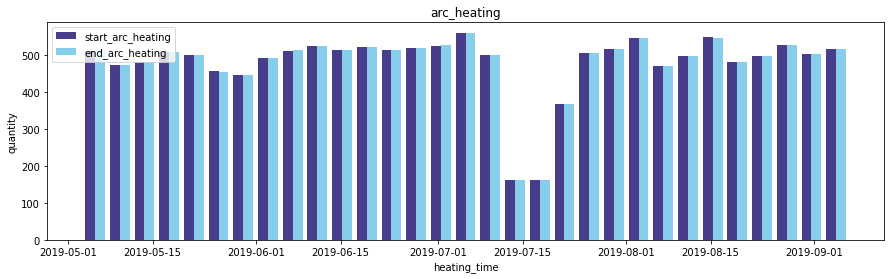

In [48]:
# Рассмотрим время нагрева дугой
plt.figure(figsize=(15,4))

plt.title('arc_heating')

x1 = list(data_arc_new['start_arc_heating'])
x2 = list(data_arc_new['end_arc_heating'])

colors = ['DarkSlateBlue', 'SkyBlue']
names = ['start_arc_heating', 'end_arc_heating']

plt.hist([x1, x2], bins='auto', color = colors, label=names)
plt.legend(#loc=4 
    #bbox_to_anchor=(0.15, 0.15)
)

plt.xlabel('heating_time')
plt.ylabel('quantity');

Проверим время нагрева, нет ли здесь аномалий.

In [49]:
# Создадим колонку со временем нагрева

data_arc_new['heating_time'] = data_arc_new['end_arc_heating'] - data_arc_new['start_arc_heating']

In [50]:
# Проверим результат

data_arc_new.head()

,key,start_arc_heating,end_arc_heating,active_power,reactive_power,heating_time
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305,0.211,0 days 00:03:48
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.766,0.477,0 days 00:03:05
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580,0.430,0 days 00:02:52
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518,0.380,0 days 00:06:05
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867,0.644,0 days 00:02:28


In [51]:
# Для дальнейшей работы, создадим колонку со временем нагрева в секундах

data_arc_new['heating_time_sec'] = data_arc_new['heating_time'].dt.seconds

In [52]:
data_arc_new.head()

,key,start_arc_heating,end_arc_heating,active_power,reactive_power,heating_time,heating_time_sec
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305,0.211,0 days 00:03:48,228
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.766,0.477,0 days 00:03:05,185
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580,0.430,0 days 00:02:52,172
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518,0.380,0 days 00:06:05,365
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867,0.644,0 days 00:02:28,148


In [53]:
# Проверим тип данных новой колонки

data_arc_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype          
---  ------             --------------  -----          
 0   key                14876 non-null  int64          
 1   start_arc_heating  14876 non-null  datetime64[ns] 
 2   end_arc_heating    14876 non-null  datetime64[ns] 
 3   active_power       14876 non-null  float64        
 4   reactive_power     14876 non-null  float64        
 5   heating_time       14876 non-null  timedelta64[ns]
 6   heating_time_sec   14876 non-null  int64          
dtypes: datetime64[ns](2), float64(2), int64(2), timedelta64[ns](1)
memory usage: 813.7 KB


In [54]:
# Выведем описание

data_arc_new.describe()

,key,active_power,reactive_power,heating_time,heating_time_sec
count,14876.000,14876.000,14876.000,14876,14876.000
mean,1615.220,0.663,0.439,0 days 00:02:51.670946490,171.671
std,934.572,0.259,5.873,0 days 00:01:38.186802680,98.187
min,1.000,0.223,-715.480,0 days 00:00:11,11.000
25%,806.000,0.467,0.337,0 days 00:01:47,107.000
50%,1617.000,0.600,0.442,0 days 00:02:27,147.000
75%,2429.000,0.830,0.608,0 days 00:03:34,214.000
max,3241.000,1.464,1.270,0 days 00:15:07,907.000


Минимальное вермя нагрева составляет 11 сек., максимальное 15 мин. Среднее время нагрева 2,51 мин.

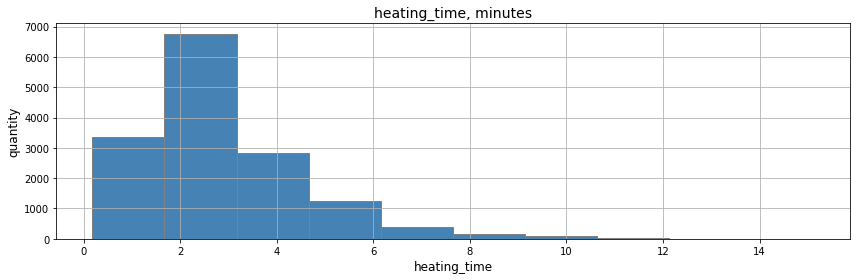

In [55]:
# heating_time Гистограмма

fig, axs = plt.subplots(figsize=(12, 4))

features = ['heating_time']

(data_arc_new.heating_time.astype('timedelta64[s]') / 60).plot.hist(figsize = (12,4), color='SteelBlue', edgecolor='gray')
axs.set_title('heating_time, minutes', fontsize=14)
axs.set_xlabel('heating_time', fontsize=12)
axs.set_ylabel('quantity', fontsize=12)
axs.grid(True)

plt.tight_layout()
plt.show();

Основная часть партий металла нагревается до 6 минут.

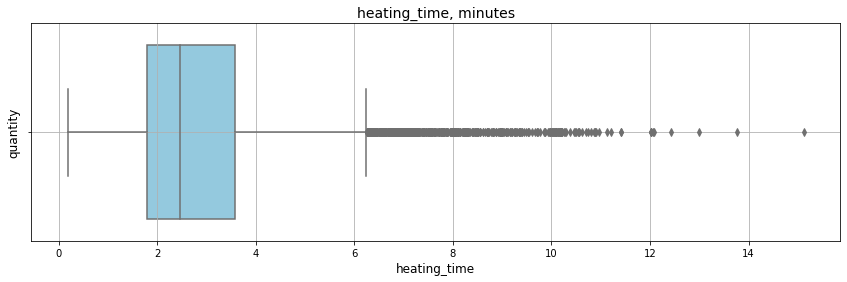

In [56]:
# heating_time Гистограмма

fig, axs = plt.subplots(figsize=(14.5, 4))

sns.boxplot(x=(data_arc_new.heating_time.astype('timedelta64[s]')/60), color='SkyBlue')

axs.set_title('heating_time, minutes', fontsize=14)
axs.set_xlabel('heating_time', fontsize=12)
axs.set_ylabel('quantity', fontsize=12)
axs.grid(True)


Boxplot определяет значения от ~ 1,9 до 3,8 как наиболее частые. Значения от 6,1 - выбросы, от 12 - редкие значения.

Медиана признака = 0.5995865


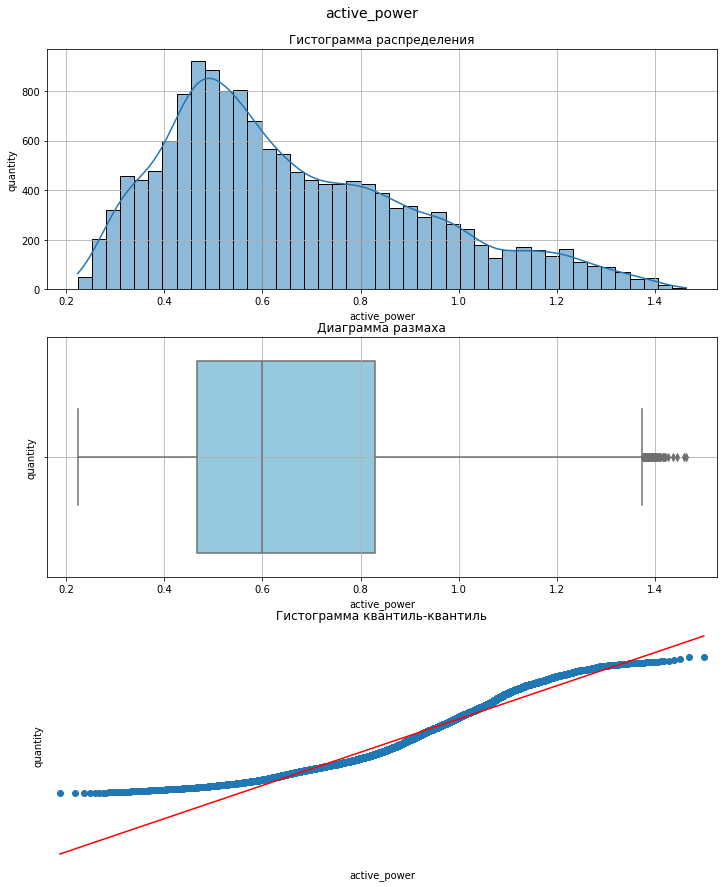

In [57]:
# Визуализируем распределение признака active_power в файле  data_arc_new

fig, axes = plt.subplots(3,1, figsize=(12,15))
fig.suptitle(f"active_power", size=14, y=0.92)

sns.histplot(x=data_arc_new.active_power, ax=axes[0], kde=True, bins='auto');

axes[0].set_title(f'Гистограмма распределения', fontsize=12)
axes[0].set_xlabel('active_power', fontsize=10)
axes[0].set_ylabel('quantity')
axes[0].grid()

sns.boxplot(x=data_arc_new.active_power, color='SkyBlue', ax=axes[1])
axes[1].set_title('Диаграмма размаха', fontsize=12)
axes[1].set_xlabel('active_power', fontsize=10)
axes[1].set_ylabel('quantity')
axes[1].grid()

qqplot(data=data_arc_new.active_power, ax=axes[2], line='s') 
axes[2].set_title(f'Гистограмма квантиль-квантиль', fontsize=12)
axes[2].set_xlabel('active_power', fontsize=10) 
axes[2].set_ylabel('quantity')
axes[2].grid()

plt.box(False)  
plt.xticks([])

plt.yticks([])

fig.show()  

print(f'Медиана признака = {np.median(data_arc_new.active_power)}')

Медиана признака = 0,6. 
Диапазон стандартных значений: ~ от 0,45 до 0,82.
Значения выше 1,39 относятся к выбросам.
График распределен не равномерно.

Поскольку в показателе reactive_power есть аномально низкое значение, посмотрим сначала ящик с усами

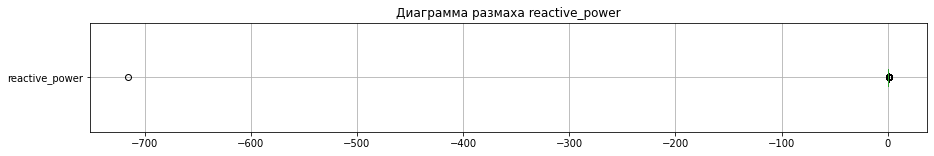

In [58]:
# Построим диаграмму размаха для reactive_power

fig, ax = plt.subplots(figsize = (15,2))
ax = data_arc_new[['reactive_power']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха reactive_power');

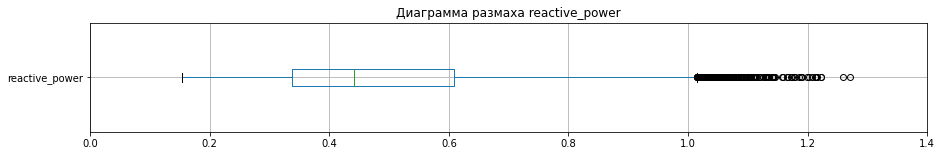

In [59]:
# Ограничим ось X

fig, ax = plt.subplots(figsize = (15,2))
ax = data_arc_new[['reactive_power']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха reactive_power')
ax.set_xlim(0,1.4);

In [60]:
# Выведем значения меньше 0

data_arc_new[data_arc_new['reactive_power']<0]

,key,start_arc_heating,end_arc_heating,active_power,reactive_power,heating_time,heating_time_sec
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705,-715.480,0 days 00:01:49,109


Такое значение всего одно, и это явная аномалия.

In [61]:
# Посмотрим на остальные записи для этой плавки

data_arc_new[data_arc_new['key']==2116]

,key,start_arc_heating,end_arc_heating,active_power,reactive_power,heating_time,heating_time_sec
9778,2116,2019-07-28 02:07:12,2019-07-28 02:09:14,0.788,0.694,0 days 00:02:02,122
9779,2116,2019-07-28 02:13:10,2019-07-28 02:15:25,0.580,0.411,0 days 00:02:15,135
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705,-715.480,0 days 00:01:49,109
9781,2116,2019-07-28 02:29:11,2019-07-28 02:30:18,0.564,0.409,0 days 00:01:07,67


Значение это нам не нужно, но совсем удлать его или всю плавку не хочется.

Попробуем заменить на отношение активной мощности записи с отрицательным значением к среднему отношению активной мощности к реактивной в данной плавке на активную мощность.

In [62]:
val = (data_arc_new.query("key == 2116 and reactive_power > 0")['active_power'] / 
data_arc_new.query("key == 2116 and reactive_power > 0")['reactive_power']).mean()

In [63]:
val

1.3082843893193157

In [64]:
# Заменим на среднее значение reactive_power

data_arc_new.loc[data_arc_new['reactive_power'] < 0, 'reactive_power'] = \
data_arc_new.query(
    "key == 2116 and reactive_power < 0"
)['active_power'] / (((data_arc_new.query(
    "key == 2116 and reactive_power > 0"
)['active_power']) / data_arc_new.query("key == 2116 and reactive_power > 0")['reactive_power']).mean())

In [65]:
# Проверим

data_arc_new[data_arc_new['key']==2116]

,key,start_arc_heating,end_arc_heating,active_power,reactive_power,heating_time,heating_time_sec
9778,2116,2019-07-28 02:07:12,2019-07-28 02:09:14,0.788,0.694,0 days 00:02:02,122
9779,2116,2019-07-28 02:13:10,2019-07-28 02:15:25,0.580,0.411,0 days 00:02:15,135
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705,0.539,0 days 00:01:49,109
9781,2116,2019-07-28 02:29:11,2019-07-28 02:30:18,0.564,0.409,0 days 00:01:07,67


Выглядит похожим на правду. Пожалуй, оставим это решение.

In [66]:
# Описание данных теперь будет:

data_arc_new.describe()

,key,active_power,reactive_power,heating_time,heating_time_sec
count,14876.000,14876.000,14876.000,14876,14876.000
mean,1615.220,0.663,0.487,0 days 00:02:51.670946490,171.671
std,934.572,0.259,0.198,0 days 00:01:38.186802680,98.187
min,1.000,0.223,0.154,0 days 00:00:11,11.000
25%,806.000,0.467,0.337,0 days 00:01:47,107.000
50%,1617.000,0.600,0.442,0 days 00:02:27,147.000
75%,2429.000,0.830,0.608,0 days 00:03:34,214.000
max,3241.000,1.464,1.270,0 days 00:15:07,907.000


Медиана признака = 0.441667


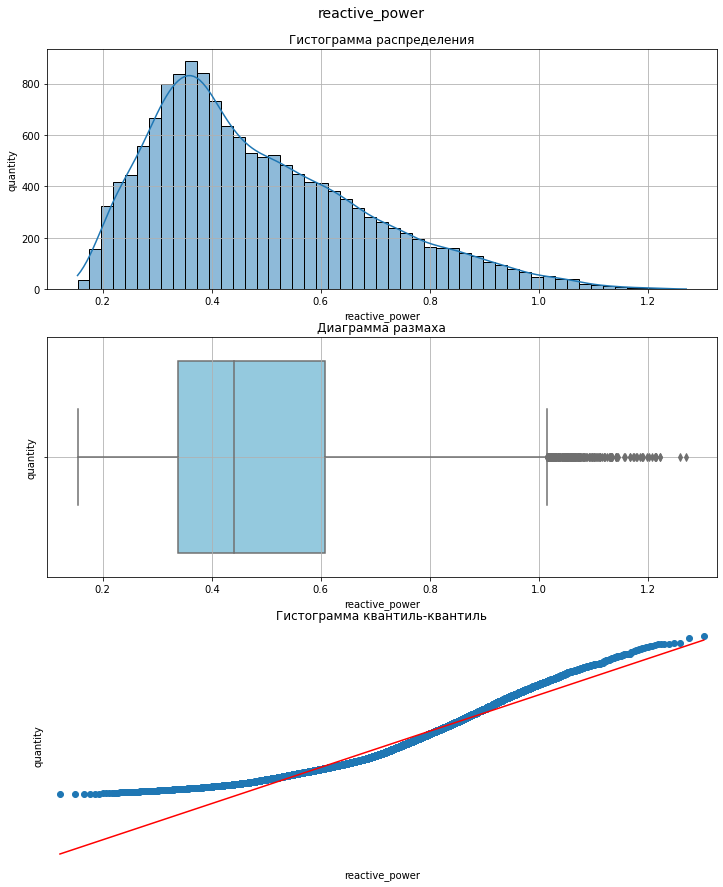

In [67]:
# Визуализируем распределение признака reactive_power

fig, axes = plt.subplots(3,1, figsize=(12,15))
fig.suptitle(f"reactive_power", size=14, y=0.92)

sns.histplot(x=data_arc_new.reactive_power, ax=axes[0], kde=True, bins='auto');

axes[0].set_title(f'Гистограмма распределения', fontsize=12)
axes[0].set_xlabel('reactive_power', fontsize=10)
axes[0].set_ylabel('quantity')
axes[0].grid()

sns.boxplot(x=data_arc_new.reactive_power, color='SkyBlue', ax=axes[1])
axes[1].set_title('Диаграмма размаха', fontsize=12)
axes[1].set_xlabel('reactive_power', fontsize=10)
axes[1].set_ylabel('quantity')
axes[1].grid()

qqplot(data=data_arc_new.reactive_power, ax=axes[2], line='s') 
axes[2].set_title(f'Гистограмма квантиль-квантиль', fontsize=12)
axes[2].set_xlabel('reactive_power', fontsize=10) 
axes[2].set_ylabel('quantity')
axes[2].grid()

plt.box(False)  
plt.xticks([])

plt.yticks([])

fig.show()  

print(f'Медиана признака = {np.median(data_arc_new.reactive_power)}')

Теперь признак выглядит гораздо более приемлемо.

Медиана = 0.4
Диапазон стандартных значений: ~ от 0,35 до 0,6.
Значения выше 1,01 относятся к выбросам.
График распределен не равномерно.

Медиана признака = 9.836267334


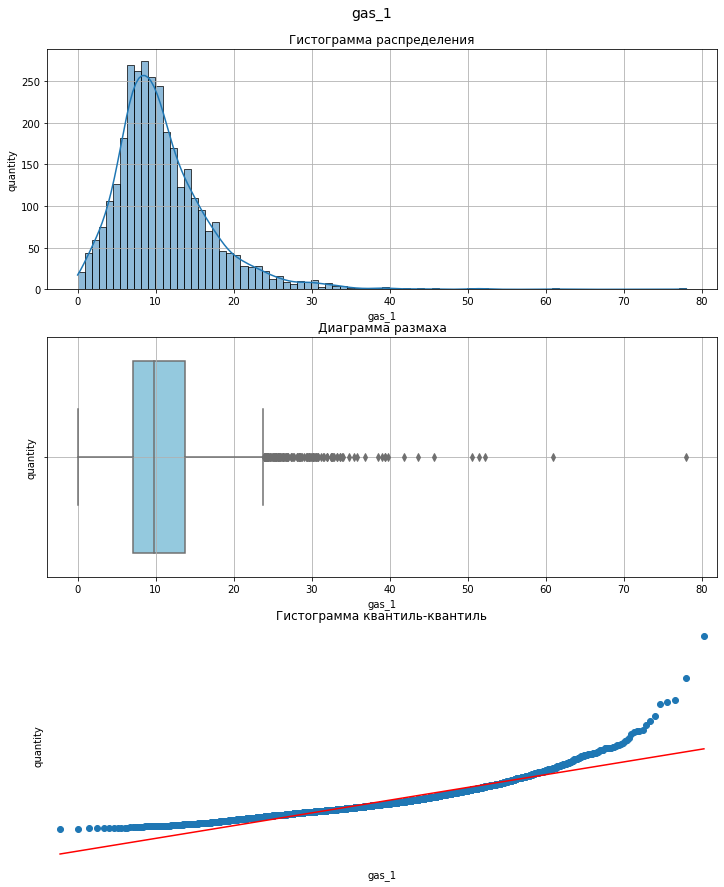

In [68]:
# Визуализируем распределение признака gas_1

fig, axes = plt.subplots(3,1, figsize=(12,15))
fig.suptitle(f"gas_1", size=14, y=0.92)

sns.histplot(x=data_gas_new.gas_1, ax=axes[0], kde=True, bins='auto');

axes[0].set_title(f'Гистограмма распределения', fontsize=12)
axes[0].set_xlabel('gas_1', fontsize=10)
axes[0].set_ylabel('quantity')
axes[0].grid()

sns.boxplot(x=data_gas_new.gas_1, color='SkyBlue', ax=axes[1])
axes[1].set_title('Диаграмма размаха', fontsize=12)
axes[1].set_xlabel('gas_1', fontsize=10)
axes[1].set_ylabel('quantity')
axes[1].grid()

qqplot(data=data_gas_new.gas_1, ax=axes[2], line='s') 
axes[2].set_title(f'Гистограмма квантиль-квантиль', fontsize=12)
axes[2].set_xlabel('gas_1', fontsize=10) 
axes[2].set_ylabel('quantity')
axes[2].grid()

plt.box(False)  
plt.xticks([])

plt.yticks([])

fig.show()  

print(f'Медиана признака = {np.median(data_gas_new.gas_1)}')

Медиана признака = 9.8. Стандартные значения: ~ от 7 до 14. Значения выше 24 относятся к выбросам. 

Есть 5 максимальных значений больше 50 - возможно, это аномалии.

Признак распределен не равномерно.

In [69]:
# Рассмотрим значения выше 50

data_gas_new[data_gas_new['gas_1']>50]

,key,gas_1
116,117,50.581
277,280,60.936
319,322,77.995
2107,2110,52.142
2567,2570,51.380


Удалять их не стоит, возможно, это связано с особенностями партии металла, т.к. у нас есть и время нагрева дугой до 15 минут.

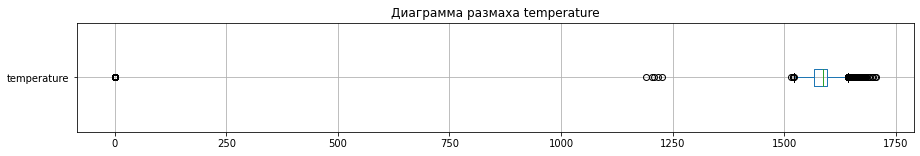

In [70]:
# Построим диаграмму размаха для temperature

fig, ax = plt.subplots(figsize = (15,2))
ax = data_temp_new[['temperature']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха temperature');

Технологический процесс предполагает, что температура плавки не должна быть ниже 1500 градусов.

In [71]:
# Выведем значения меньше 1500

data_temp_new[data_temp_new['temperature']<1500]

,key,measure_time,temperature
4883,867,2019-06-06 08:03:39,1191.000
6784,1214,2019-06-18 08:01:03,1208.000
9050,1619,2019-07-03 02:34:41,1218.000
11495,2052,2019-07-25 08:49:15,1227.000
13927,2500,2019-08-10 14:13:11,0.000
...,...,...,...
18087,3241,2019-09-06 16:55:01,0.000
18088,3241,2019-09-06 17:06:38,0.000
18089,3241,2019-09-06 17:21:48,0.000
18090,3241,2019-09-06 17:24:44,0.000


Учитывая температуру плавления, значения меньше 1500 следует удалить. Тем более, что их всего 5.

Также мы заменили на 0 отсутствующие значения. Поскольку температура важный показатель, а пропуски мы не сможем никак восполнить, стоит удалить и эти значения тоже.

In [72]:
data_temp_new = data_temp_new[data_temp_new['temperature']>=1500]

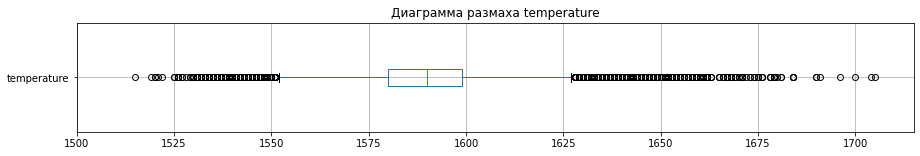

In [73]:
# Ограничим ось X

fig, ax = plt.subplots(figsize = (15,2))
ax = data_temp_new[['temperature']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха temperature')
ax.set_xlim(1500,1715);

In [74]:
data_temp_new

,key,measure_time,temperature
0,1,2019-05-03 11:02:04,1571.000
1,1,2019-05-03 11:07:18,1604.000
2,1,2019-05-03 11:11:34,1618.000
3,1,2019-05-03 11:18:04,1601.000
4,1,2019-05-03 11:25:59,1606.000
...,...,...,...
18061,3237,2019-09-06 11:31:15,1569.000
18067,3238,2019-09-06 12:16:15,1584.000
18071,3239,2019-09-06 14:16:50,1598.000
18080,3240,2019-09-06 15:25:21,1617.000


Поскольку последнее значение температуры является таргетом, то нам нужно удалить записи с единственным измерением температуры.

Найдем эти значения.

In [75]:
# Создадим таблицу со значением температуры и количеством записей

temp = pd.pivot_table(data_temp_new, index=['key'], values = ['temperature'], aggfunc = 'count')

In [76]:
# Посчитаем число записей с единствнным значением температуры

temp[temp['temperature']==1].count()

temperature    740
dtype: int64

In [77]:
# Список ключей с единичной температурой

temp_list = temp[temp['temperature']==1].index
temp_list

Int64Index([ 195,  279, 2500, 2501, 2502, 2503, 2504, 2505, 2506, 2507,
            ...
            3232, 3233, 3234, 3235, 3236, 3237, 3238, 3239, 3240, 3241],
           dtype='int64', name='key', length=740)

In [78]:
# Рассмотрим строки, которые будут удалены

data_temp_new.query('key in @temp_list')

,key,measure_time,temperature
1105,195,2019-05-11 00:01:36,1583.000
1549,279,2019-05-14 10:13:01,1603.000
13926,2500,2019-08-10 14:04:39,1539.000
13931,2501,2019-08-10 14:41:14,1587.000
13938,2502,2019-08-10 15:39:39,1583.000
...,...,...,...
18061,3237,2019-09-06 11:31:15,1569.000
18067,3238,2019-09-06 12:16:15,1584.000
18071,3239,2019-09-06 14:16:50,1598.000
18080,3240,2019-09-06 15:25:21,1617.000


In [79]:
# Для проверки - число строк в датафрейме до удаления

data_temp_new.shape

(14660, 3)

In [80]:
# Удалим строки с единственной температурой

data_temp_new = data_temp_new.query('key not in @temp_list')

Проверим

In [81]:
data_temp_new.shape

(13920, 3)

In [82]:
data_temp_new.key.unique()

array([   1,    2,    3, ..., 2497, 2498, 2499])

In [83]:
data_temp_new

,key,measure_time,temperature
0,1,2019-05-03 11:02:04,1571.000
1,1,2019-05-03 11:07:18,1604.000
2,1,2019-05-03 11:11:34,1618.000
3,1,2019-05-03 11:18:04,1601.000
4,1,2019-05-03 11:25:59,1606.000
...,...,...,...
13921,2499,2019-08-10 13:33:21,1569.000
13922,2499,2019-08-10 13:41:34,1604.000
13923,2499,2019-08-10 13:46:28,1593.000
13924,2499,2019-08-10 13:54:56,1588.000


Медиана признака = 1590.0


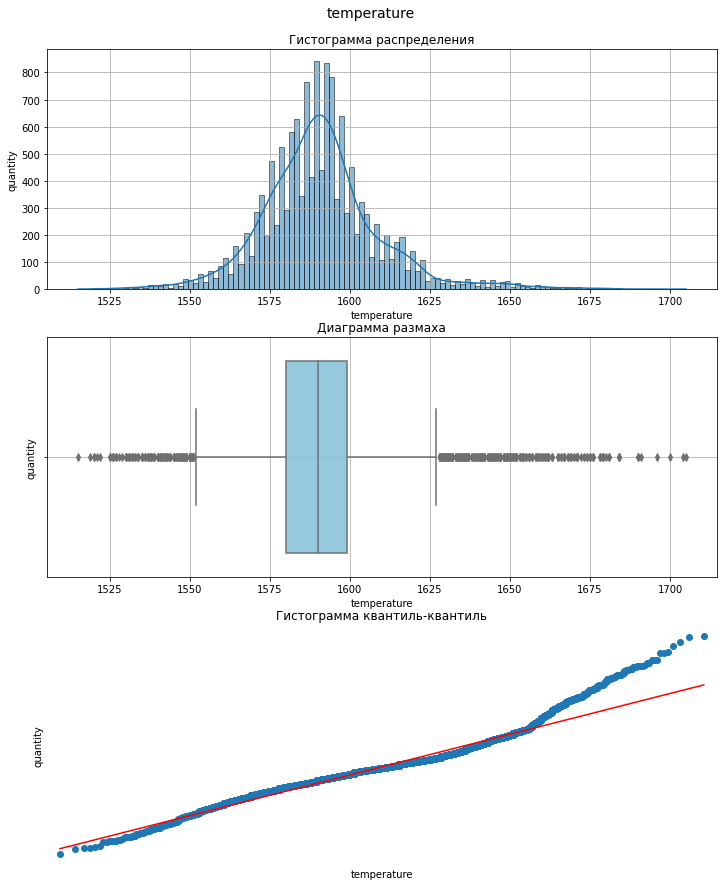

In [84]:
# Визуализируем распределение признака temperature

fig, axes = plt.subplots(3,1, figsize=(12,15))
fig.suptitle(f"temperature", size=14, y=0.92)

sns.histplot(x=data_temp_new.temperature, ax=axes[0], kde=True, bins='auto');

axes[0].set_title(f'Гистограмма распределения', fontsize=12)
axes[0].set_xlabel('temperature', fontsize=10)
axes[0].set_ylabel('quantity')
axes[0].grid()

sns.boxplot(x=data_temp_new.temperature, color='SkyBlue', ax=axes[1])
axes[1].set_title('Диаграмма размаха', fontsize=12)
axes[1].set_xlabel('temperature', fontsize=10)
axes[1].set_ylabel('quantity')
axes[1].grid()

qqplot(data=data_temp_new.temperature, ax=axes[2], line='s') 
axes[2].set_title(f'Гистограмма квантиль-квантиль', fontsize=12)
axes[2].set_xlabel('temperature', fontsize=10) 
axes[2].set_ylabel('quantity')
axes[2].grid()

plt.box(False)  
plt.xticks([])

plt.yticks([])

fig.show()  

print(f'Медиана признака = {np.median(data_temp_new.temperature)}')

Медиана = 1590.
Стандартные значения от 1580 до 1599. 

Значения до 1551 и выше 1626 относятся к выбросам.

Признак распределен не равномерно.

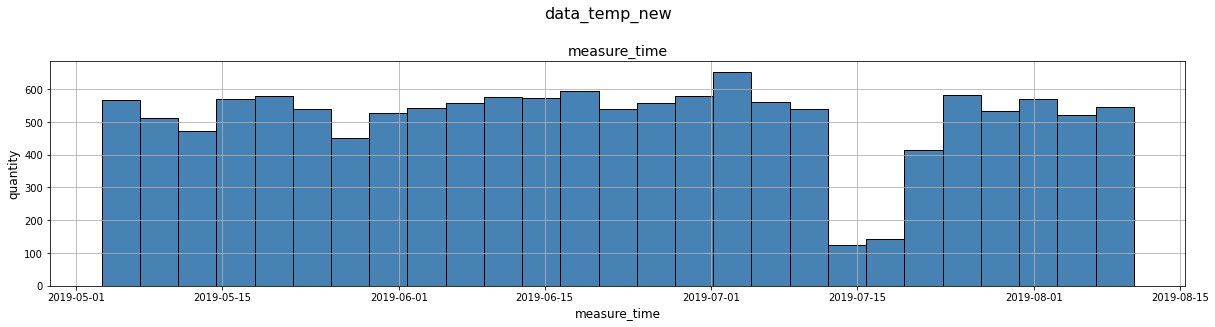

In [85]:
# data_temp_new measure_time Гистограмма

fig, axs = plt.subplots(figsize=(17, 4.5))
fig.suptitle(f"data_temp_new", size=16, y=1.0)

data_temp_new.measure_time.hist(bins='auto', color='steelblue', edgecolor='black')
axs.set_title('measure_time', fontsize=14)
axs.set_xlabel('measure_time', fontsize=12)
axs.set_ylabel('quantity', fontsize=12)
axs.grid(True)

plt.tight_layout()
plt.show();

Количество измерений температуры довольно равномерно. Есть провал с ~ 10 по 20 июля 2019г.

Далее рассмотрим объемы и время добавления сыпучих материалов и проволки.

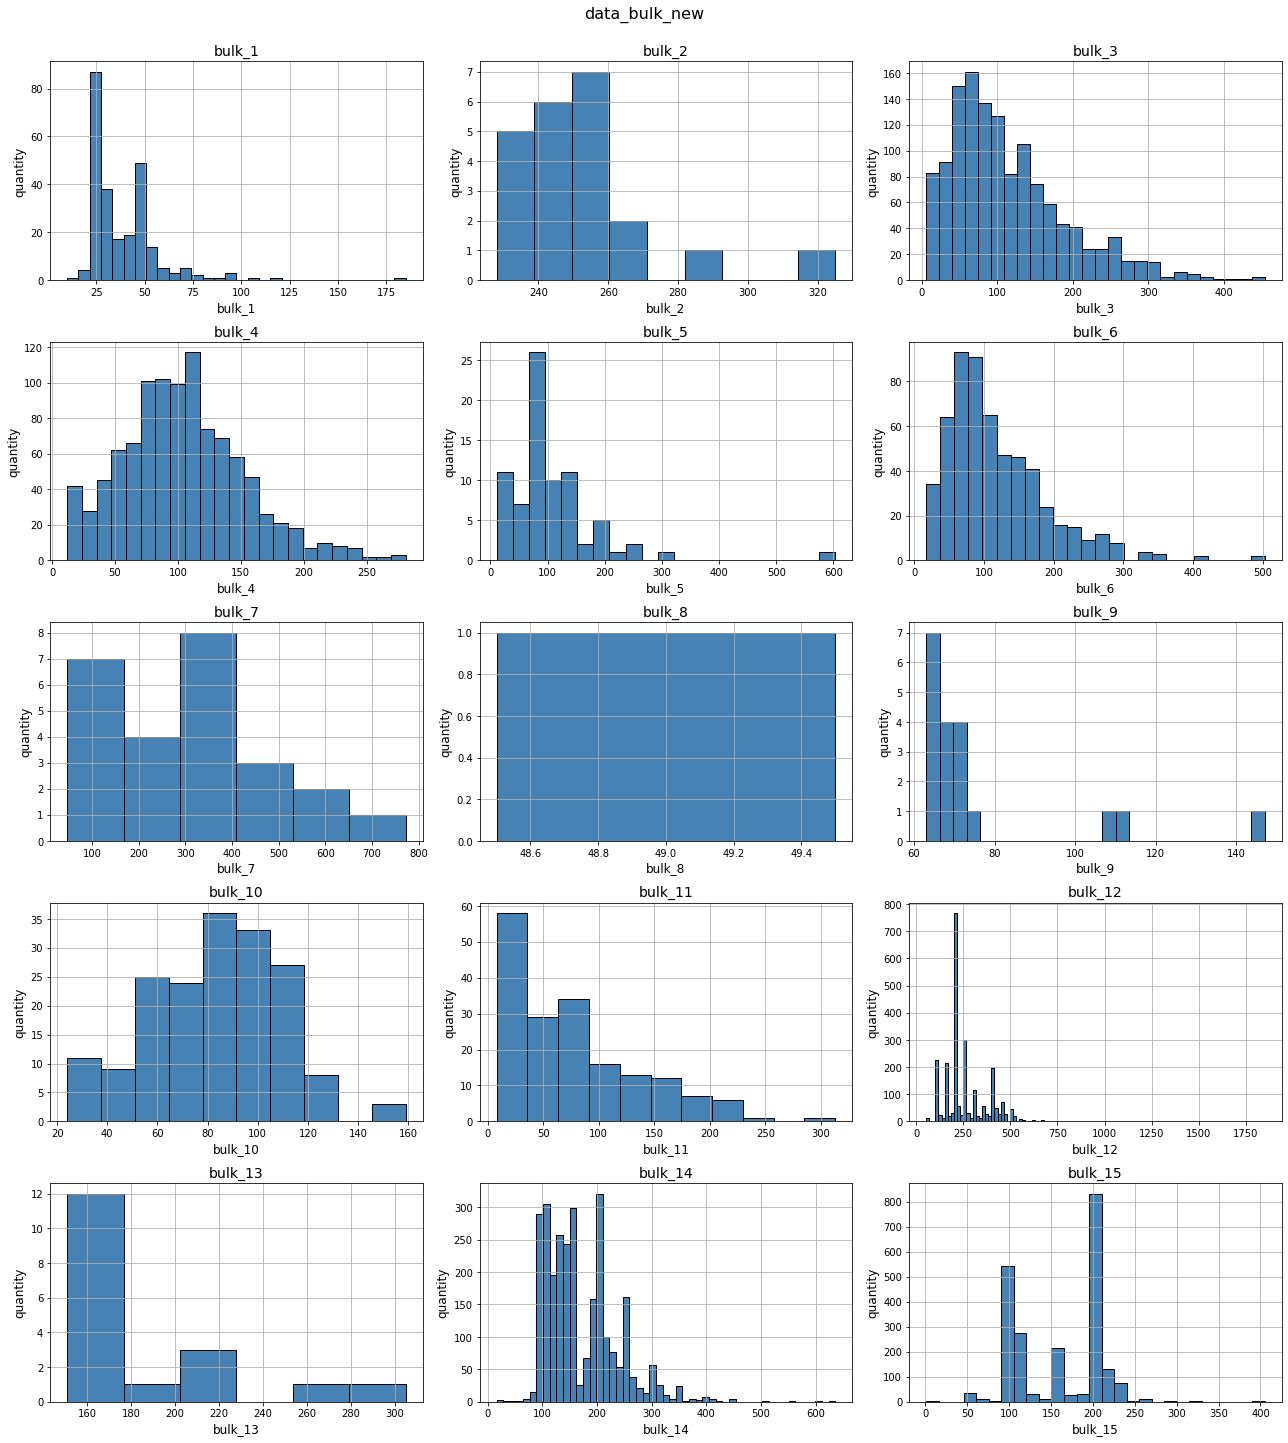

In [86]:
# data_bulk_new Гистограммы

# Названия графиков

plot_titles = ['bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15']

# Подписи для осей X и Y

x_labels = ['bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15']

y_labels = ['quantity']*(len(data_bulk_new.columns)-1)

# Используем цикл для построения гистограмм каждого признака

fig, axs = plt.subplots(5, 3, figsize=(18, 20))
axs = axs.flatten()
fig.suptitle(f"data_bulk_new", size=16, y=1.0)

features = ['bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15']

for i, feature in enumerate(features):
    axs[i].hist(data_bulk_new[feature], bins='auto', color='steelblue', edgecolor='black')
    axs[i].set_title(plot_titles[i], fontsize=14)
    axs[i].set_xlabel(x_labels[i], fontsize=12)
    axs[i].set_ylabel(y_labels[i], fontsize=12)
    axs[i].grid(True)

#plt.box(False) 
#plt.xticks([])
#plt.yticks([])

plt.tight_layout()
plt.show();

Гистограммы показывают, что разные виды сыпучих материалов используются с разной интенсивностью и в различных объемах.

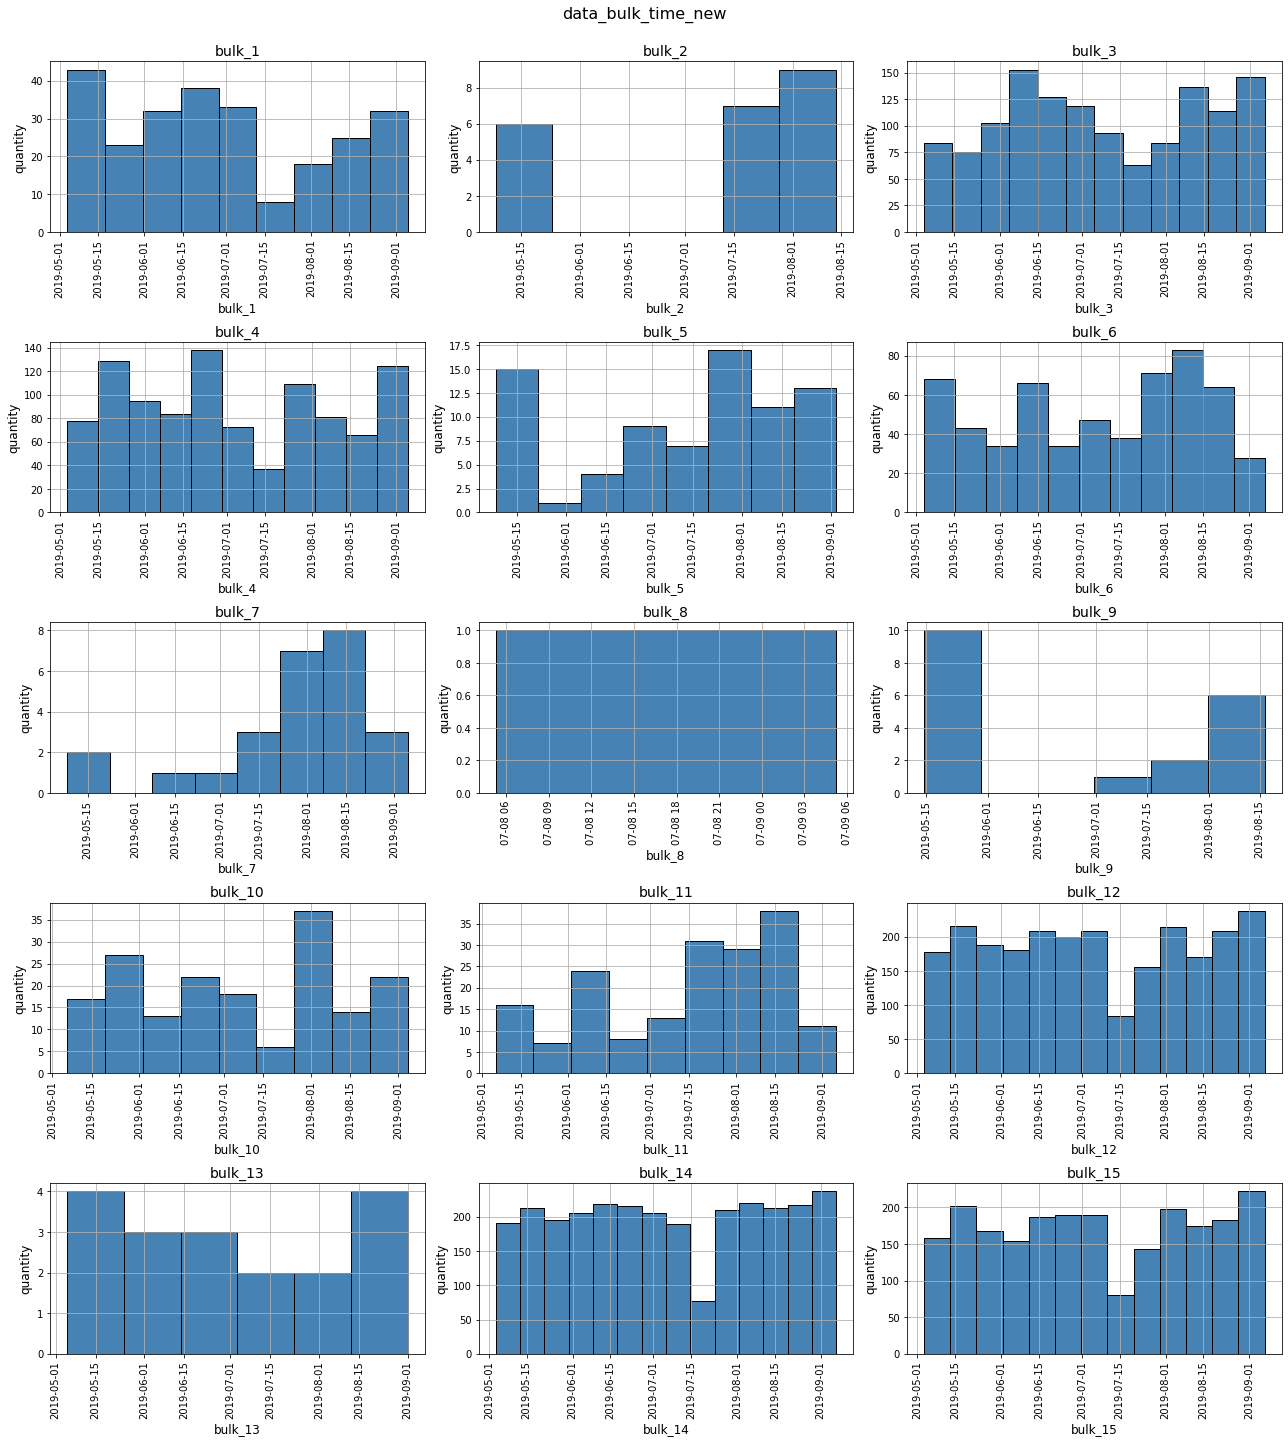

In [87]:
# data_bulk_time_new Гистограммы

# Названия графиков

plot_titles = ['bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15']

# Подписи для осей X и Y

x_labels = ['bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15']

y_labels = ['quantity']*(len(data_bulk_time_new.columns)-1)

# Используем цикл для построения гистограмм каждого признака

fig, axs = plt.subplots(5, 3, figsize=(18, 20))
axs = axs.flatten()
fig.suptitle(f"data_bulk_time_new", size=16, y=1.0)

features = ['bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15']

for i, feature in enumerate(features):
    axs[i].hist(data_bulk_time_new[feature], bins='auto', color='steelblue', edgecolor='black')
    axs[i].set_title(plot_titles[i], fontsize=14)
    axs[i].set_xlabel(x_labels[i], fontsize=12)
    axs[i].set_ylabel(y_labels[i], fontsize=12)
    axs[i].tick_params(axis='x', labelrotation=90)
    axs[i].grid(True)

#plt.box(False) 
#plt.xticks([])
#plt.yticks([])

plt.tight_layout()
plt.show();

Также мы видим, что некоторые материалы используются во всех плавках, а некоторые материалы применяются выборочно.

Наиболее часто используются bulk_12, bulk_14, bulk_15.

Bulk_8 используется, единожды

С проволокой, как мы увидим дальше, похожая ситуация.

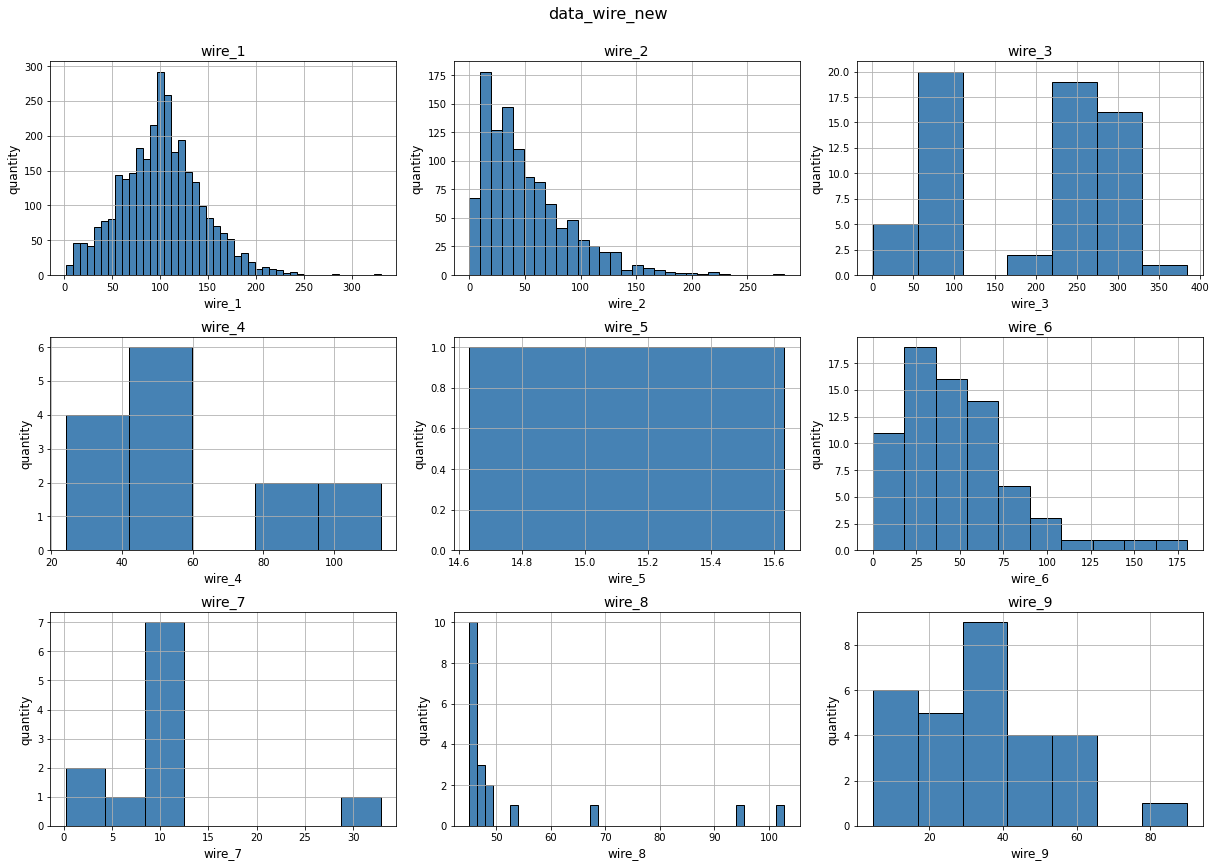

In [88]:
# data_bulk_time_new Гистограммы

# Названия графиков

plot_titles = ['wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
       'wire_7', 'wire_8', 'wire_9']

# Подписи для осей X и Y

x_labels = ['wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
       'wire_7', 'wire_8', 'wire_9']

y_labels = ['quantity']*(len(data_wire_new.columns)-1)

# Используем цикл для построения гистограмм каждого признака

fig, axs = plt.subplots(3, 3, figsize=(17, 12))
axs = axs.flatten()
fig.suptitle(f"data_wire_new", size=16, y=1.0)

features = ['wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
       'wire_7', 'wire_8', 'wire_9']

for i, feature in enumerate(features):
    axs[i].hist(data_wire_new[feature], bins='auto', color='steelblue', edgecolor='black')
    axs[i].set_title(plot_titles[i], fontsize=14)
    axs[i].set_xlabel(x_labels[i], fontsize=12)
    axs[i].set_ylabel(y_labels[i], fontsize=12)
    axs[i].grid(True)

#plt.box(False) 
#plt.xticks([])
#plt.yticks([])

plt.tight_layout()
plt.show();

Наибольший объем показывают wire_1, wire_2.

wire_4, wire_7, wire_8, пожалуй, самые редко-применяемые

И единичное использование мы видим для wire_5.

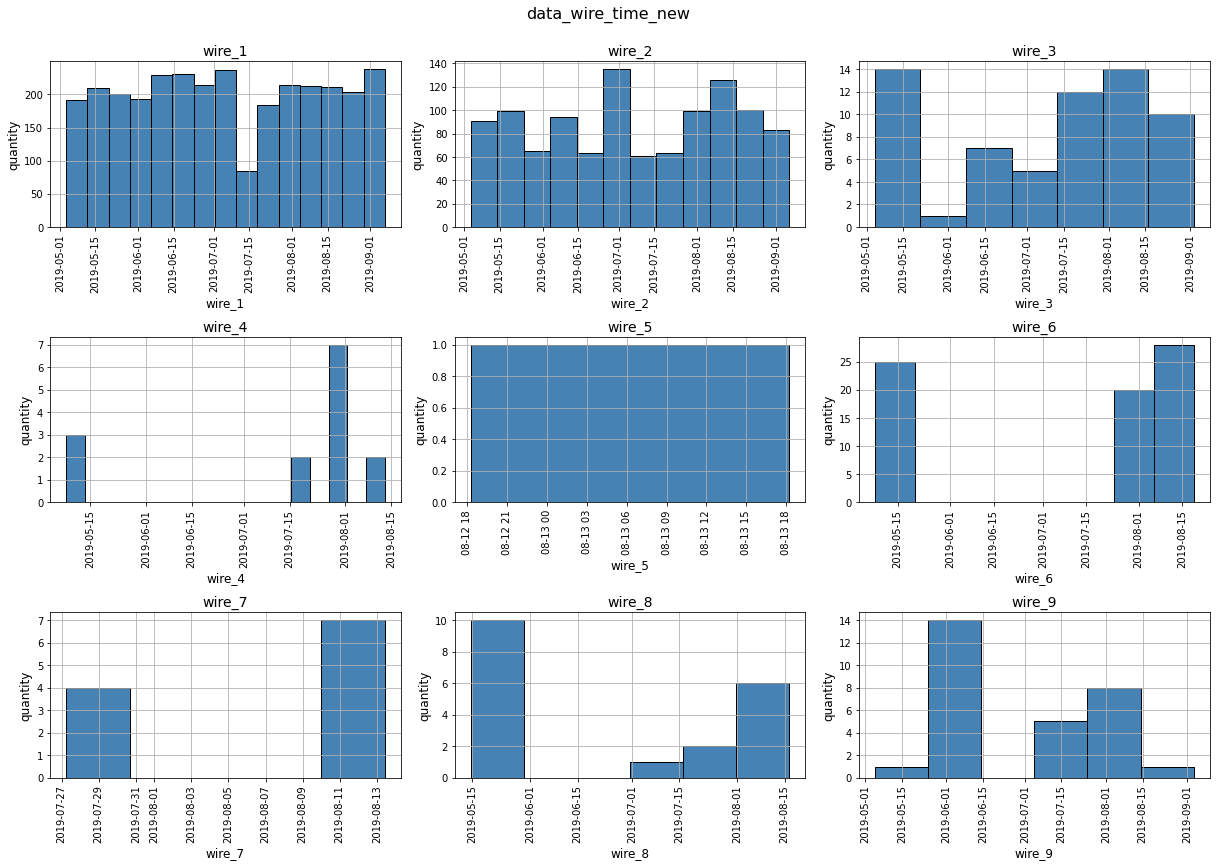

In [89]:
# data_bulk_time_new Гистограммы

# Названия графиков

plot_titles = ['wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
       'wire_7', 'wire_8', 'wire_9']

# Подписи для осей X и Y

x_labels = ['wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
       'wire_7', 'wire_8', 'wire_9']

y_labels = ['quantity']*(len(data_wire_time_new.columns)-1)

# Используем цикл для построения гистограмм каждого признака

fig, axs = plt.subplots(3, 3, figsize=(17, 12))
axs = axs.flatten()
fig.suptitle(f"data_wire_time_new", size=16, y=1.0)

features = ['wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
       'wire_7', 'wire_8', 'wire_9']

for i, feature in enumerate(features):
    axs[i].hist(data_wire_time_new[feature], bins='auto', color='steelblue', edgecolor='black')
    axs[i].set_title(plot_titles[i], fontsize=14)
    axs[i].set_xlabel(x_labels[i], fontsize=12)
    axs[i].set_ylabel(y_labels[i], fontsize=12)
    axs[i].tick_params(axis='x', labelrotation=90)
    axs[i].grid(True)

#plt.box(False) 
#plt.xticks([])
#plt.yticks([])

plt.tight_layout()
plt.show();

По времени ситуация повторяет картину объемов.

Определим наиболее важные признаки

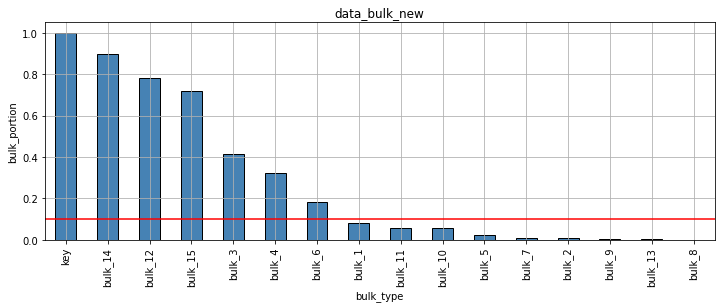

In [90]:
# Для сыпучих добавок

plt.figure(figsize = (12,4))
ax = (~data_bulk_new.isnull()).mean().sort_values(ascending=False).plot(kind = 'bar', color='steelblue', edgecolor='black')
ax.axhline(y=0.1, linestyle='-', color='r')
ax.set_title('data_bulk_new')
ax.set_ylabel('bulk_portion')
ax.set_xlabel('bulk_type')
ax.grid(True);

Часть сыпучих материалов применяется менее чем в 10% плавок.

Наиболее значимые сыучие материалы: bulk_14, bulk_12, bulk_15, bulk_3, bulk_4, bulk_6. 

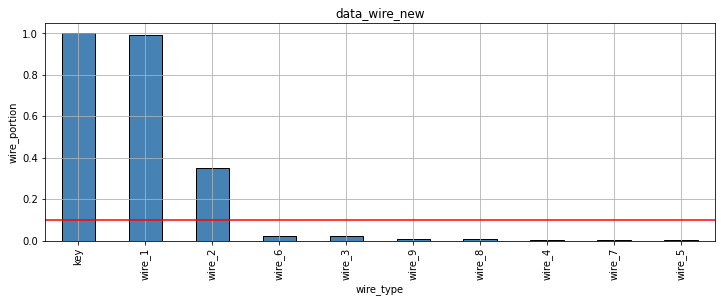

In [91]:
# Для проволки

plt.figure(figsize = (12,4))
ax = (~data_wire_new.isnull()).mean().sort_values(ascending=False).plot(kind = 'bar', color='steelblue', edgecolor='black')
ax.axhline(y=0.1, linestyle='-', color='r')
ax.set_title('data_wire_new')
ax.set_ylabel('wire_portion')
ax.set_xlabel('wire_type')
ax.grid(True);

Для проволки аналогично: 7 малозначимых признаков, которые использованы в менее чем 10% плавок.

Наиболее значимые: wire_1, wire_2.

Теперь можно заменить пропуски на нули.

In [92]:
data_bulk_new[['bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11',
               'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15']] = \
data_bulk_new[['bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11',
               'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15']].fillna(0)

Проверим

In [93]:
data_bulk_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   3129 non-null   float64
 2   bulk_2   3129 non-null   float64
 3   bulk_3   3129 non-null   float64
 4   bulk_4   3129 non-null   float64
 5   bulk_5   3129 non-null   float64
 6   bulk_6   3129 non-null   float64
 7   bulk_7   3129 non-null   float64
 8   bulk_8   3129 non-null   float64
 9   bulk_9   3129 non-null   float64
 10  bulk_10  3129 non-null   float64
 11  bulk_11  3129 non-null   float64
 12  bulk_12  3129 non-null   float64
 13  bulk_13  3129 non-null   float64
 14  bulk_14  3129 non-null   float64
 15  bulk_15  3129 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [94]:
data_bulk_new.head()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,0.000,0.000,0.000,43.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,206.000,0.000,150.000,154.000
1,2,0.000,0.000,0.000,73.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,206.000,0.000,149.000,154.000
2,3,0.000,0.000,0.000,34.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,205.000,0.000,152.000,153.000
3,4,0.000,0.000,0.000,81.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,207.000,0.000,153.000,154.000
4,5,0.000,0.000,0.000,78.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,203.000,0.000,151.000,152.000


In [95]:
data_bulk_time_new[['bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 
                    'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15']] = \
data_bulk_time_new[['bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10',
                    'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15']].fillna(0)

Проверим

In [96]:
data_bulk_time_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   bulk_1   3129 non-null   object
 2   bulk_2   3129 non-null   object
 3   bulk_3   3129 non-null   object
 4   bulk_4   3129 non-null   object
 5   bulk_5   3129 non-null   object
 6   bulk_6   3129 non-null   object
 7   bulk_7   3129 non-null   object
 8   bulk_8   3129 non-null   object
 9   bulk_9   3129 non-null   object
 10  bulk_10  3129 non-null   object
 11  bulk_11  3129 non-null   object
 12  bulk_12  3129 non-null   object
 13  bulk_13  3129 non-null   object
 14  bulk_14  3129 non-null   object
 15  bulk_15  3129 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [97]:
data_bulk_time_new.head()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,0,0,0,2019-05-03 11:28:48,0,0,0,0,0,0,0,2019-05-03 11:24:31,0,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,0,0,0,2019-05-03 11:36:50,0,0,0,0,0,0,0,2019-05-03 11:53:30,0,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,0,0,0,2019-05-03 12:32:39,0,0,0,0,0,0,0,2019-05-03 12:27:13,0,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,0,0,0,2019-05-03 12:43:22,0,0,0,0,0,0,0,2019-05-03 12:58:00,0,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,0,0,0,2019-05-03 13:30:47,0,0,0,0,0,0,0,2019-05-03 13:30:47,0,2019-05-03 13:34:12,2019-05-03 13:30:47


In [98]:
data_wire_new[['wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9']] = \
data_wire_new[['wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9']].fillna(0)

Проверим

In [99]:
data_wire_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3081 non-null   float64
 2   wire_2  3081 non-null   float64
 3   wire_3  3081 non-null   float64
 4   wire_4  3081 non-null   float64
 5   wire_5  3081 non-null   float64
 6   wire_6  3081 non-null   float64
 7   wire_7  3081 non-null   float64
 8   wire_8  3081 non-null   float64
 9   wire_9  3081 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [100]:
data_wire_new.head()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.060,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,2,96.052,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,3,91.160,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,4,89.064,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,5,89.238,9.115,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [101]:
data_wire_time_new[['wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9']] = \
data_wire_time_new[['wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9']].fillna(0)

Проверим

In [102]:
data_wire_time_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   wire_1  3081 non-null   object
 2   wire_2  3081 non-null   object
 3   wire_3  3081 non-null   object
 4   wire_4  3081 non-null   object
 5   wire_5  3081 non-null   object
 6   wire_6  3081 non-null   object
 7   wire_7  3081 non-null   object
 8   wire_8  3081 non-null   object
 9   wire_9  3081 non-null   object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [103]:
data_wire_time_new.head()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,2019-05-03 11:06:19,0,0,0,0,0,0,0,0
1,2,2019-05-03 11:36:50,0,0,0,0,0,0,0,0
2,3,2019-05-03 12:11:46,0,0,0,0,0,0,0,0
3,4,2019-05-03 12:43:22,0,0,0,0,0,0,0,0
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,0,0,0,0,0,0,0


На всякий случай выведем номер партии, в которой единственный раз встречаются bulk_8 и wire_5

In [104]:
data_bulk_new[data_bulk_new['bulk_8'] !=0]

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
1725,1786,0.000,0.000,123.000,0.000,0.000,0.000,0.000,49.000,147.000,0.000,0.000,0.000,0.000,0.000,0.000


In [105]:
data_arc_new[data_arc_new['key']==1786]

,key,start_arc_heating,end_arc_heating,active_power,reactive_power,heating_time,heating_time_sec
8213,1786,2019-07-08 16:54:41,2019-07-08 16:56:35,0.341,0.237,0 days 00:01:54,114
8214,1786,2019-07-08 17:02:21,2019-07-08 17:07:29,0.365,0.320,0 days 00:05:08,308
8215,1786,2019-07-08 17:13:17,2019-07-08 17:14:34,0.336,0.262,0 days 00:01:17,77
8216,1786,2019-07-08 17:21:06,2019-07-08 17:23:09,0.584,0.364,0 days 00:02:03,123


In [106]:
data_wire_new[data_wire_new['wire_5'] !=0]

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
2440,2567,18.302,0.000,96.288,0.000,15.132,73.308,0.000,0.000,0.000


In [107]:
data_arc_new[data_arc_new['key']==2567]

,key,start_arc_heating,end_arc_heating,active_power,reactive_power,heating_time,heating_time_sec
11790,2567,2019-08-13 05:30:55,2019-08-13 05:33:14,0.479,0.392,0 days 00:02:19,139
11791,2567,2019-08-13 05:34:47,2019-08-13 05:36:44,0.717,0.496,0 days 00:01:57,117
11792,2567,2019-08-13 05:37:50,2019-08-13 05:38:49,0.803,0.520,0 days 00:00:59,59
11793,2567,2019-08-13 05:47:49,2019-08-13 05:48:44,0.616,0.472,0 days 00:00:55,55
11794,2567,2019-08-13 05:51:16,2019-08-13 05:52:22,0.288,0.155,0 days 00:01:06,66
11795,2567,2019-08-13 05:57:52,2019-08-13 06:00:30,0.335,0.304,0 days 00:02:38,158
11796,2567,2019-08-13 06:02:37,2019-08-13 06:04:46,0.473,0.343,0 days 00:02:09,129
11797,2567,2019-08-13 06:08:44,2019-08-13 06:10:25,0.548,0.383,0 days 00:01:41,101
11798,2567,2019-08-13 06:12:15,2019-08-13 06:14:16,0.577,0.381,0 days 00:02:01,121
11799,2567,2019-08-13 07:02:45,2019-08-13 07:04:24,0.532,0.360,0 days 00:01:39,99


**Вывод:**

На данном этапе были обнаружены аномальные значения в признаке температура и реактивная мощность.
Аномальный отрицательный показатель реактивной мощности заменен на долю активной мощности среднюю по данной плавке.

В данных нет дубликатов. Однако выявлено очень большое число пропусков в покзателях температуры и лигирующих добавок.
Пропуски в температуре удалены, т.к. это целевой признак. Пропуски в лигирующих добавках заменены на нули, т.к. они отражают особенности технологического процесса.

Определены группы лигирующих добавок с числом пропусков больше 80%:
* bulk_1 , bulk_2 , bulk_5 , bulk_6 , bulk_7 , bulk_9 , bulk_10 , bulk_11, bulk_13
  bulk_8 - единичное применение за весь период наблюдений
* wire_3, wire_4, wire_6, wire_7, wire_8, wire_9 
  wire_5 - единичное применение за весь период наблюдений
  
Анализ гистограмм бокс-плотов показывает, что данные не имеют нормального распределения и содержат выбросы. Однако удалять их не следует, т.к. это связано с разными видами плавок и особенностями технологического процесса (разное количество и время засыпки лигирующих добавок, разные температуры и время нагрева, число итераций нагрева и т.д.)

Поскольку технологический процесс предполагает нагревание стали до 1500 градусов, значения температур ниже этого значения были удалены. Также удалены плавки с отсутсвующими и единичными показателями температур, т.к. это целевой признак.

## Объединение данных

Поскольку после группировки, данные будут агрерированны, мне кажется, стоит сначала добавить несколько новых показателей в таблицу с электродами.

In [108]:
# Добавим общую мощность

data_arc_new['total_power'] = (data_arc_new['active_power']**2 + data_arc_new['reactive_power']**2)**(1/2)

Создадим вспомогательные таблицы

In [109]:
# Суммарные мощности

df_arc_powers = data_arc_new.groupby('key').sum()[['active_power', 'reactive_power', 'total_power']].reset_index()
df_arc_powers.head(2)

,key,active_power,reactive_power,total_power
0,1,3.037,2.143,3.719
1,2,2.139,1.453,2.588


In [110]:
# Суммарное время нагрева

df_arc_heat = data_arc_new.groupby('key').sum()[['heating_time_sec']].reset_index()
df_arc_heat.head(2)

,key,heating_time_sec
0,1,1098
1,2,811


In [111]:
# Число итераций нагрева

df_arc_count = data_arc_new.groupby('key').count()[['start_arc_heating']].reset_index()
df_arc_count.columns = ['key', 'heat_iterations']
df_arc_count.head(2)

,key,heat_iterations
0,1,5
1,2,4


Время нагрева не включаем в итоговый датасет.

In [112]:
# Первый замер температуры

df_temp_first = data_temp_new.groupby('key').first().reset_index()
df_temp_first.columns = ['key', 'first_temp_measure', 'first_temperature']
df_temp_first.head(2)

,key,first_temp_measure,first_temperature
0,1,2019-05-03 11:02:04,1571.000
1,2,2019-05-03 11:34:04,1581.000


In [113]:
# Последний замер температуры

df_temp_last = data_temp_new.groupby('key').last().reset_index()
df_temp_last.columns = ['key', 'last_temp_measure', 'last_temperature']
df_temp_last.head(2)

,key,last_temp_measure,last_temperature
0,1,2019-05-03 11:30:38,1613.000
1,2,2019-05-03 11:55:09,1602.000


In [114]:
# Показатели газа представлены в единичном значении для каждой плавки.

(data_gas_new.key.value_counts()>1).sum()

0

In [115]:
# Сыпучие материалы суммарно

df_bulk_sum = data_bulk_new.groupby('key').sum().reset_index()
df_bulk_sum.head(2)

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,0.000,0.000,0.000,43.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,206.000,0.000,150.000,154.000
1,2,0.000,0.000,0.000,73.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,206.000,0.000,149.000,154.000


In [116]:
# Проволочные материалы суммарно

df_wire_sum = data_wire_new.groupby('key').sum().reset_index()
df_wire_sum.head(2)

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.060,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,2,96.052,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [117]:
 df = df_arc_powers.merge(
     df_arc_heat, how='inner', on='key').merge(
     df_arc_count, how='inner', on='key').merge(
     df_temp_first, how='inner', on='key').merge(
     df_temp_last, how='inner', on='key').merge(
     data_gas_new, how='inner', on='key').merge(
     df_bulk_sum, how='inner', on='key').merge(
     df_wire_sum, how='inner', on='key')

In [118]:
# Посмотрим общий вид итоговой таблицы

df.tail()

,key,active_power,reactive_power,total_power,heating_time_sec,heat_iterations,first_temp_measure,first_temperature,last_temp_measure,last_temperature,gas_1,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
2324,2495,3.168,2.211,3.869,723,4,2019-08-10 11:27:47,1570.000,2019-08-10 11:50:47,1591.000,7.126,0.000,0.000,21.000,0.000,0.000,0.000,0.000,0.000,0.000,90.000,0.000,256.000,0.000,129.000,223.000,89.151,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2325,2496,4.175,2.872,5.070,940,6,2019-08-10 11:56:48,1554.000,2019-08-10 12:25:13,1591.000,9.413,0.000,0.000,0.000,63.000,0.000,0.000,0.000,0.000,0.000,122.000,0.000,256.000,0.000,129.000,226.000,114.180,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2326,2497,3.605,2.452,4.361,569,3,2019-08-10 12:37:26,1571.000,2019-08-10 12:53:28,1589.000,6.272,0.000,0.000,0.000,85.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,230.000,0.000,124.000,226.000,94.087,9.048,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2327,2498,3.202,2.240,3.910,750,5,2019-08-10 12:58:11,1591.000,2019-08-10 13:23:31,1594.000,14.954,0.000,0.000,90.000,0.000,0.000,0.000,0.000,0.000,0.000,101.000,0.000,206.000,0.000,129.000,207.000,118.111,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2328,2499,1.737,1.297,2.169,883,4,2019-08-10 13:33:21,1569.000,2019-08-10 13:58:58,1603.000,11.336,0.000,0.000,47.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,233.000,0.000,126.000,227.000,110.161,50.005,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [119]:
df[(df['key']==2567)|(df['key']==1786)]

,key,active_power,reactive_power,total_power,heating_time_sec,heat_iterations,first_temp_measure,first_temperature,last_temp_measure,last_temperature,gas_1,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
1667,1786,1.626,1.183,2.015,622,4,2019-07-08 16:54:31,1574.000,2019-07-08 17:29:11,1579.000,12.648,0.000,0.000,123.000,0.000,0.000,0.000,0.000,49.000,147.000,0.000,0.000,0.000,0.000,0.000,0.000,175.219,48.286,0.000,0.000,0.000,0.000,0.000,68.494,0.000


Наверное, все же стоит удалить эту партию.

In [120]:
df = df.query('key != 1786')

In [121]:
df[(df['key']==2567)|(df['key']==1786)]

,key,active_power,reactive_power,total_power,heating_time_sec,heat_iterations,first_temp_measure,first_temperature,last_temp_measure,last_temperature,gas_1,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9


In [122]:
df[df['wire_5'] !=0]

,key,active_power,reactive_power,total_power,heating_time_sec,heat_iterations,first_temp_measure,first_temperature,last_temp_measure,last_temperature,gas_1,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9


In [123]:
# Удалим колонку wire_5

df.drop(['bulk_8','wire_5'], axis=1, inplace=True)

In [124]:
# Удалим ключи

df.drop('key', axis=1, inplace=True)

In [125]:
df.head()

,active_power,reactive_power,total_power,heating_time_sec,heat_iterations,first_temp_measure,first_temperature,last_temp_measure,last_temperature,gas_1,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9
0,3.037,2.143,3.719,1098,5,2019-05-03 11:02:04,1571.000,2019-05-03 11:30:38,1613.000,29.750,0.000,0.000,0.000,43.000,0.000,0.000,0.000,0.000,0.000,0.000,206.000,0.000,150.000,154.000,60.060,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,2.139,1.453,2.588,811,4,2019-05-03 11:34:04,1581.000,2019-05-03 11:55:09,1602.000,12.556,0.000,0.000,0.000,73.000,0.000,0.000,0.000,0.000,0.000,0.000,206.000,0.000,149.000,154.000,96.052,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,4.064,2.937,5.019,655,5,2019-05-03 12:06:44,1596.000,2019-05-03 12:35:57,1599.000,28.555,0.000,0.000,0.000,34.000,0.000,0.000,0.000,0.000,0.000,0.000,205.000,0.000,152.000,153.000,91.160,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,2.706,2.057,3.400,741,4,2019-05-03 12:39:27,1601.000,2019-05-03 12:59:47,1625.000,18.841,0.000,0.000,0.000,81.000,0.000,0.000,0.000,0.000,0.000,0.000,207.000,0.000,153.000,154.000,89.064,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,2.253,1.688,2.817,869,4,2019-05-03 13:11:03,1576.000,2019-05-03 13:36:39,1602.000,5.414,0.000,0.000,0.000,78.000,0.000,0.000,0.000,0.000,0.000,0.000,203.000,0.000,151.000,152.000,89.238,9.115,0.000,0.000,0.000,0.000,0.000,0.000


In [126]:
df.head()

,active_power,reactive_power,total_power,heating_time_sec,heat_iterations,first_temp_measure,first_temperature,last_temp_measure,last_temperature,gas_1,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9
0,3.037,2.143,3.719,1098,5,2019-05-03 11:02:04,1571.000,2019-05-03 11:30:38,1613.000,29.750,0.000,0.000,0.000,43.000,0.000,0.000,0.000,0.000,0.000,0.000,206.000,0.000,150.000,154.000,60.060,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,2.139,1.453,2.588,811,4,2019-05-03 11:34:04,1581.000,2019-05-03 11:55:09,1602.000,12.556,0.000,0.000,0.000,73.000,0.000,0.000,0.000,0.000,0.000,0.000,206.000,0.000,149.000,154.000,96.052,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,4.064,2.937,5.019,655,5,2019-05-03 12:06:44,1596.000,2019-05-03 12:35:57,1599.000,28.555,0.000,0.000,0.000,34.000,0.000,0.000,0.000,0.000,0.000,0.000,205.000,0.000,152.000,153.000,91.160,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,2.706,2.057,3.400,741,4,2019-05-03 12:39:27,1601.000,2019-05-03 12:59:47,1625.000,18.841,0.000,0.000,0.000,81.000,0.000,0.000,0.000,0.000,0.000,0.000,207.000,0.000,153.000,154.000,89.064,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,2.253,1.688,2.817,869,4,2019-05-03 13:11:03,1576.000,2019-05-03 13:36:39,1602.000,5.414,0.000,0.000,0.000,78.000,0.000,0.000,0.000,0.000,0.000,0.000,203.000,0.000,151.000,152.000,89.238,9.115,0.000,0.000,0.000,0.000,0.000,0.000


**Вывод:**

На данном этапе отдельные данные объеденены в единый файл (методом INNER). Для этого предварительно созданы вспомогательные таблицы с группировкой по ключу и признаками: 
  - общая мощность
  - время нагрева
  - число итераций нагрева
  - первая температура
  - последняя температура
  - суммарный объем лигирующих добавок (по видам)
  
Удалены плавки с единичным использованием лигирующих добавок bulk_8, wire_5 и из общего файла удалены ключи (номера плавок)

## Исследовательский анализ и предобработка данных объединённого датафрейма

In [127]:
# Выведем общую информацию

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2328 entries, 0 to 2328
Data columns (total 32 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   active_power        2328 non-null   float64       
 1   reactive_power      2328 non-null   float64       
 2   total_power         2328 non-null   float64       
 3   heating_time_sec    2328 non-null   int64         
 4   heat_iterations     2328 non-null   int64         
 5   first_temp_measure  2328 non-null   datetime64[ns]
 6   first_temperature   2328 non-null   float64       
 7   last_temp_measure   2328 non-null   datetime64[ns]
 8   last_temperature    2328 non-null   float64       
 9   gas_1               2328 non-null   float64       
 10  bulk_1              2328 non-null   float64       
 11  bulk_2              2328 non-null   float64       
 12  bulk_3              2328 non-null   float64       
 13  bulk_4              2328 non-null   float64     

Итого получилось 2328 плавок, пропусков нет.

In [128]:
# Описание данных новой таблицы

df.describe()

,active_power,reactive_power,total_power,heating_time_sec,heat_iterations,first_temperature,last_temperature,gas_1,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9
count,2328.000,2328.000,2328.000,2328.000,2328.000,2328.000,2328.000,2328.000,2328.000,2328.000,2328.000,2328.000,2328.000,2328.000,2328.000,2328.000,2328.000,2328.000,2328.000,2328.000,2328.000,2328.000,2328.000,2328.000,2328.000,2328.000,2328.000,2328.000,2328.000,2328.000
mean,3.126,2.301,3.886,807.727,4.696,1587.392,1593.372,11.375,3.429,1.423,47.316,37.320,2.641,22.440,2.006,0.382,5.055,4.247,208.505,1.068,153.920,120.004,102.412,17.597,3.236,0.307,0.979,0.006,0.282,0.317
std,1.221,0.904,1.518,340.890,1.607,23.623,11.199,6.393,12.415,19.086,75.310,58.651,22.407,55.801,30.683,5.429,20.922,22.520,157.037,14.238,81.359,84.622,43.523,33.626,27.949,4.759,8.695,0.206,4.171,3.457
min,0.268,0.196,0.332,57.000,1.000,1519.000,1541.000,0.008,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,2.296,1.671,2.847,581.000,4.000,1571.000,1587.000,7.283,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,105.000,0.000,105.000,0.000,73.205,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,3.036,2.226,3.769,778.000,5.000,1587.000,1593.000,10.101,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,206.000,0.000,149.000,107.000,101.104,0.000,0.000,0.000,0.000,0.000,0.000,0.000
75%,3.834,2.829,4.770,993.000,6.000,1603.000,1598.000,14.217,0.000,0.000,80.000,77.250,0.000,0.000,0.000,0.000,0.000,0.000,282.250,0.000,204.000,204.000,128.075,23.103,0.000,0.000,0.000,0.000,0.000,0.000
max,12.376,8.949,15.288,4189.000,16.000,1660.000,1653.000,77.995,185.000,325.000,454.000,281.000,603.000,503.000,772.000,111.000,159.000,313.000,1849.000,305.000,636.000,405.000,330.314,282.780,385.009,113.231,180.455,8.490,102.762,62.026


Распределение данных выглядит равномерно.

Максимальное значение сильно отличается по всем показателям: от времени нагрева (~ 70 минут) до показателей лигирующих добавок, мощности, количества итераций нагрева (16) и количества измерений температуры (17).

In [129]:
# Число полных дубликатов

df.duplicated().sum()

0

In [130]:
# Добавим новый признак work

df['work'] = df['total_power']*df['heating_time_sec']

In [131]:
# Добавим признак время между замерами температуры

df['time_interval'] = (df['last_temp_measure'] - df['first_temp_measure']).dt.seconds

In [132]:
#А само время удалим

df.drop(['first_temp_measure', 'last_temp_measure'], axis=1, inplace=True)

In [133]:
df.head(2)

,active_power,reactive_power,total_power,heating_time_sec,heat_iterations,first_temperature,last_temperature,gas_1,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9,work,time_interval
0,3.037,2.143,3.719,1098,5,1571.000,1613.000,29.750,0.000,0.000,0.000,43.000,0.000,0.000,0.000,0.000,0.000,0.000,206.000,0.000,150.000,154.000,60.060,0.000,0.000,0.000,0.000,0.000,0.000,0.000,4083.172,1714
1,2.139,1.453,2.588,811,4,1581.000,1602.000,12.556,0.000,0.000,0.000,73.000,0.000,0.000,0.000,0.000,0.000,0.000,206.000,0.000,149.000,154.000,96.052,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2099.151,1265


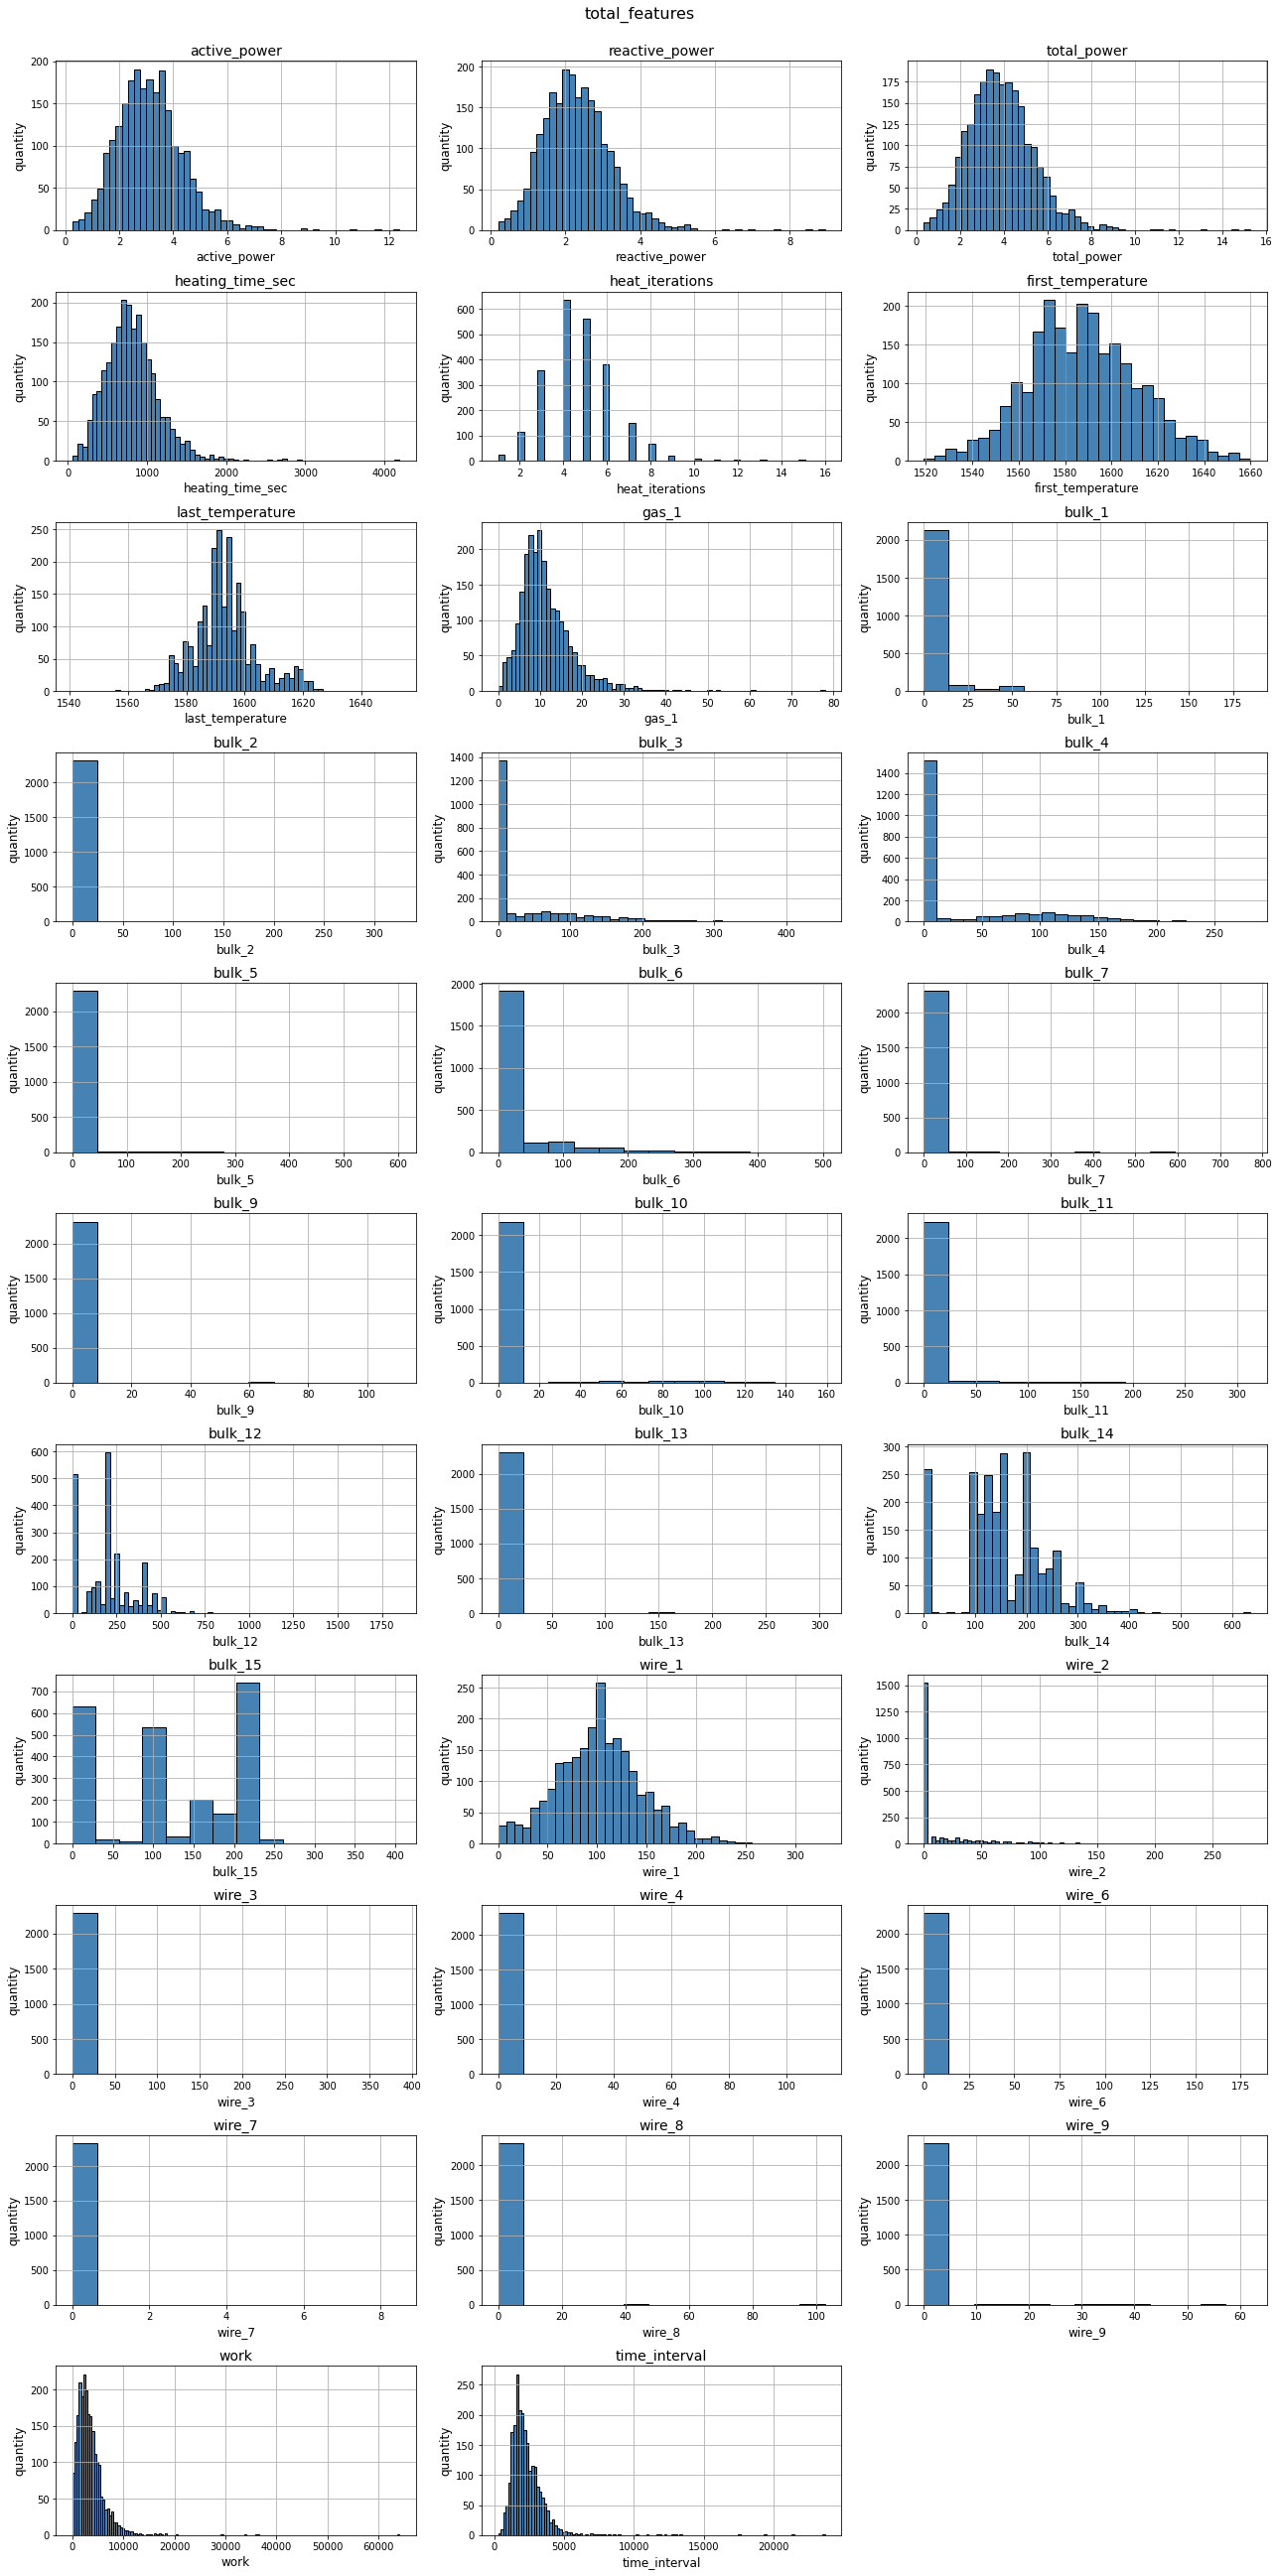

In [134]:
# Гистограммы признаков

# Названия графиков

plot_titles = df.columns

# Подписи для осей X и Y

x_labels = df.columns

y_labels = ['quantity']*(len(df.columns))

# Используем цикл для построения гистограмм каждого признака

fig, axs = plt.subplots(11, 3, figsize=(18, 36))
axs = axs.flatten()
fig.suptitle(f'total_features', size=16, y=1.0)

features = df.columns

for i, feature in enumerate(features):
    axs[i].hist(df[feature], bins='auto', color='steelblue', edgecolor='black')
    axs[i].set_title(plot_titles[i], fontsize=14)
    axs[i].set_xlabel(x_labels[i], fontsize=12)
    axs[i].set_ylabel(y_labels[i], fontsize=12)
    axs[i].grid(True)

plt.box(False) 
plt.xticks([])
plt.yticks([])

plt.tight_layout()
plt.show();

При визуальном осмотре относительно нормальными выглядят распределения last_temperature и wire_1.

Проверим их на нормальность распределения

In [135]:
# Создадим функцию для проверки нормальности распределения

def feature_distribution_coef(df, feature):
    print(f'Тест Шапиро-Уилка = {shapiro(df[feature])}')
    if shapiro(df[feature])[1] > 0.05:
        print("Есть основания полагать, что данные распределены нормально", '\n')
    else:
        print("Есть достаточно доказательств, чтобы сказать, что данные выборки НЕ имеют нормального распределения.", '\n')
            
            
    print(f'Тест Д Агостино = {normaltest(df[feature])}')
    if normaltest(df[feature])[1] > 0.05:
        print("Есть основания полагать, что данные распределены нормально", '\n')
    else:
        print("Есть достаточно доказательств, чтобы сказать, что данные выборки НЕ имеют нормального распределения.", '\n')
        
    print(f'Коэффициент асимметрии = {df[feature].skew()}')
    if df[feature].skew() < 0:
        print("Отрицательная асимметрия: хвост находится в левой части.")
        print("Распределение простирается в сторону более отрицательных значений.")
    elif df[feature].skew() == 0:
        print("Нулевая ассиметрия: распределение совершенно симметрично.")
    else:
        print("Положительная асимметрия: хвост находится в правой части.")
        print("Распределение простирается в сторону положительных значений.")

In [136]:
# Приоверим нормальность распределения признака last_temperature 

feature_distribution_coef(df, 'last_temperature')

Тест Шапиро-Уилка = ShapiroResult(statistic=0.9598242044448853, pvalue=6.854047557296707e-25)
Есть достаточно доказательств, чтобы сказать, что данные выборки НЕ имеют нормального распределения. 

Тест Д Агостино = NormaltestResult(statistic=170.7741813008772, pvalue=8.257673451041286e-38)
Есть достаточно доказательств, чтобы сказать, что данные выборки НЕ имеют нормального распределения. 

Коэффициент асимметрии = 0.4444746119176309
Положительная асимметрия: хвост находится в правой части.
Распределение простирается в сторону положительных значений.


In [137]:
# Приоверим нормальность распределения признака wire_1 

feature_distribution_coef(df, 'wire_1')

Тест Шапиро-Уилка = ShapiroResult(statistic=0.9930385947227478, pvalue=4.401490283356679e-09)
Есть достаточно доказательств, чтобы сказать, что данные выборки НЕ имеют нормального распределения. 

Тест Д Агостино = NormaltestResult(statistic=40.378229957094945, pvalue=1.7059989923163385e-09)
Есть достаточно доказательств, чтобы сказать, что данные выборки НЕ имеют нормального распределения. 

Коэффициент асимметрии = 0.25339406615792975
Положительная асимметрия: хвост находится в правой части.
Распределение простирается в сторону положительных значений.


Тесты показывают, что данные не имеют нормального распределения.
(следовательно, для анализа корреляции будем использовать коэффициенты Спирмана, а не Пирсона).

Медиана: 2045.0 сек (34.08 мин)


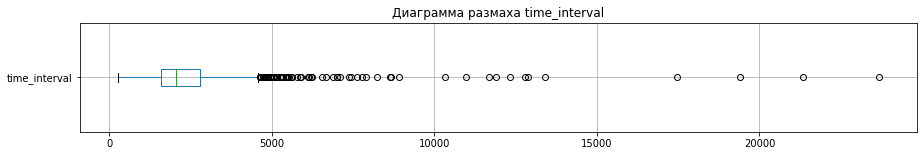

In [138]:
# Построим диаграмму размаха для time_interval

fig, ax = plt.subplots(figsize = (15,2))
ax = df[['time_interval']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха time_interval');

print(f'Медиана: {df["time_interval"].median()} сек ({round(df["time_interval"].median()/60,2)} мин)')

Значения свыше ~ 4900 сек. относятся к выбросам.

Самое продолжительное время плавки 4-5 часов. Таких значений всего 4.

In [139]:
df[df['time_interval']>15000]

,active_power,reactive_power,total_power,heating_time_sec,heat_iterations,first_temperature,last_temperature,gas_1,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9,work,time_interval
593,3.478,2.456,4.265,1413,6,1617.000,1580.000,20.985,0.000,0.000,0.000,60.000,0.000,0.000,0.000,0.000,0.000,0.000,208.000,153.000,0.000,156.000,221.177,0.000,0.000,0.000,0.000,0.000,0.000,0.000,6026.905,17467
1578,12.376,8.949,15.288,4189,15,1583.000,1606.000,33.597,0.000,0.000,0.000,0.000,0.000,247.000,0.000,0.000,0.000,0.000,733.000,305.000,248.000,224.000,187.153,0.000,0.000,0.000,0.000,0.000,0.000,0.000,64042.569,23674
1834,6.915,5.441,8.812,1834,11,1579.000,1570.000,32.450,0.000,0.000,31.000,0.000,0.000,175.000,0.000,0.000,0.000,0.000,310.000,0.000,180.000,202.000,123.309,150.106,0.961,0.000,0.000,0.000,0.000,0.000,16160.976,19409
1973,10.707,7.589,13.135,2739,16,1639.000,1541.000,45.639,63.000,242.000,0.000,98.000,94.000,0.000,507.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,11.051,0.000,93.213,92.570,63.046,1.054,0.000,0.000,35976.412,21331


Но, полагаю, их следует оставить в данных.

Корреляционный анализ признаков

Диаграмма рассеяния считается очень долго и получается совсем не читабельной. Закооментировала ее. 

#Диаграмма рассеяния всех количественных показателей

pair_plot = sns.pairplot(df, kind="kde", corner=True
                         #, hue = ''
                        )

#Поворачиваем подписи осей X и Y для каждой поддиаграммы

for ax in pair_plot.axes[-1, :]:
    ax.xaxis.label.set_rotation(45)
    ax.xaxis.label.set_ha('right')
    ax.xaxis.label.set_fontsize(12)

for ax in pair_plot.axes[:, 0]:
    #ax.yaxis.label.set_rotation(45)
    ax.yaxis.label.set_ha('right')
    ax.xaxis.label.set_fontsize(12)

#Добавляем заголовок

pair_plot.fig.suptitle('Диаграмма рассеяния признаков', fontsize=14, y=1)
plt.show();    

Мы видим линейную связь в показателях мощности.

Также bulk_1 разделяется на 3 группы, bulk_10 на 2 и bulk_15 тоже на 3. Возможно, это пригодится для подбора признаков.

Рассмотрим heatmap

Поскольку признаки не распределены равномерно, используем коэффициенты Спирмана.

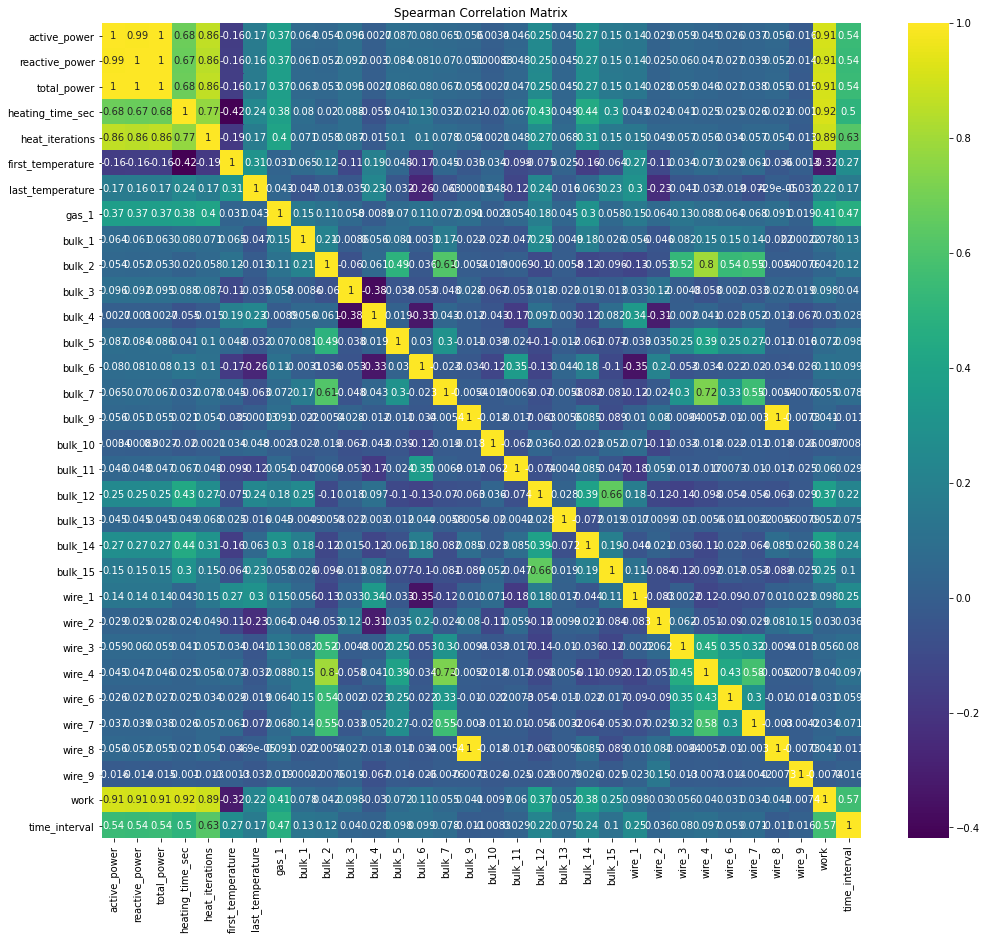

In [140]:
# Матрица корреляции признаков Спирмана

fig, ax = plt.subplots(figsize=(17, 15))
sns.heatmap(df.corr(method='spearman'), annot=True, cmap='viridis')
plt.title('Spearman Correlation Matrix');

Мультиколлинеарность в признаках мощности, а также wire_8 и bulk_9

Чтобы убрать мультиколлинеарность удалим активную и реактивную мощность, и wire_8.

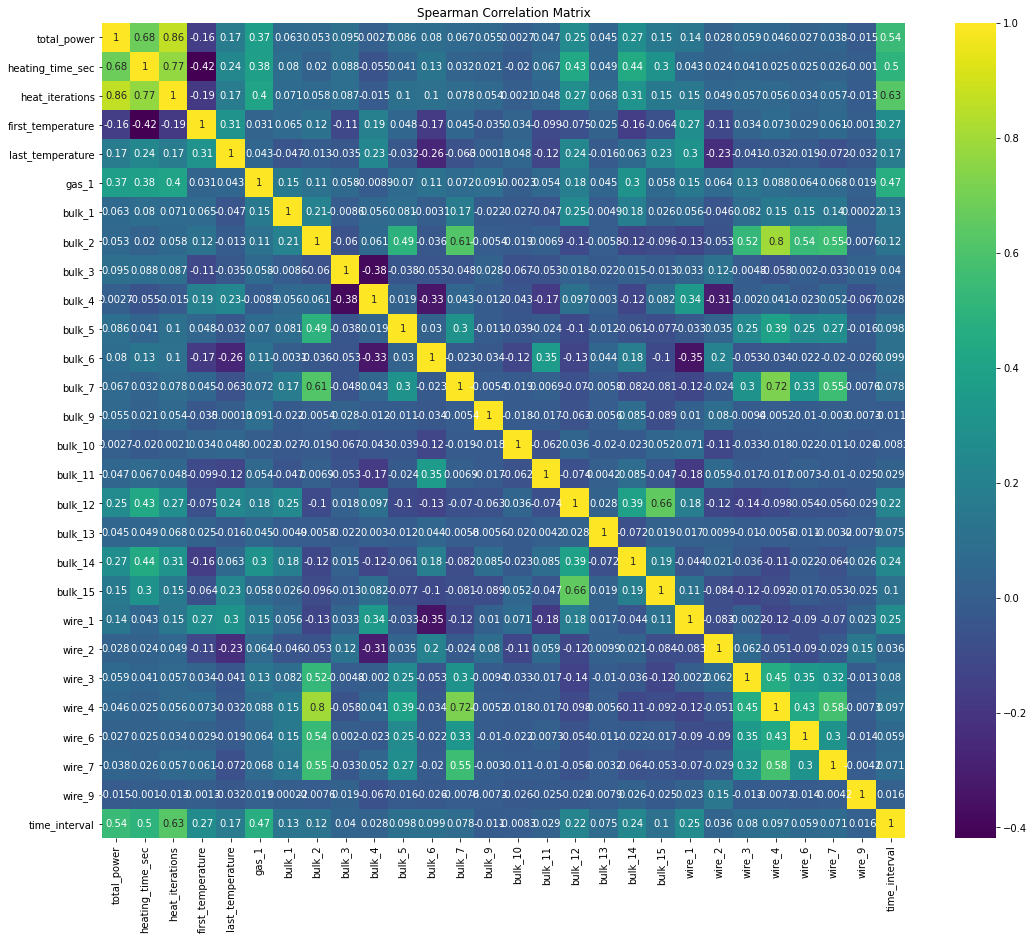

In [141]:
# Матрица корреляции признаков Спирмана без мощности и wire_8

fig, ax = plt.subplots(figsize=(18, 15))
sns.heatmap(df.drop(['active_power', 'reactive_power', 'wire_8', 'work'], axis=1).corr(method='spearman'), annot=True, cmap='viridis')
plt.title('Spearman Correlation Matrix');

In [142]:
df.columns

Index(['active_power', 'reactive_power', 'total_power', 'heating_time_sec',
       'heat_iterations', 'first_temperature', 'last_temperature', 'gas_1',
       'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7',
       'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14',
       'bulk_15', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_6', 'wire_7',
       'wire_8', 'wire_9', 'work', 'time_interval'],
      dtype='object')

In [143]:
# Определим непрерывные признаки для корреляции Фи

interval_columns = ['total_power', 'heating_time_sec',
       'heat_iterations', 'first_temperature', 'last_temperature', 'gas_1',
       'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7',
       'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14',
       'bulk_15', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_6', 'wire_7',
       'wire_9', 'time_interval']

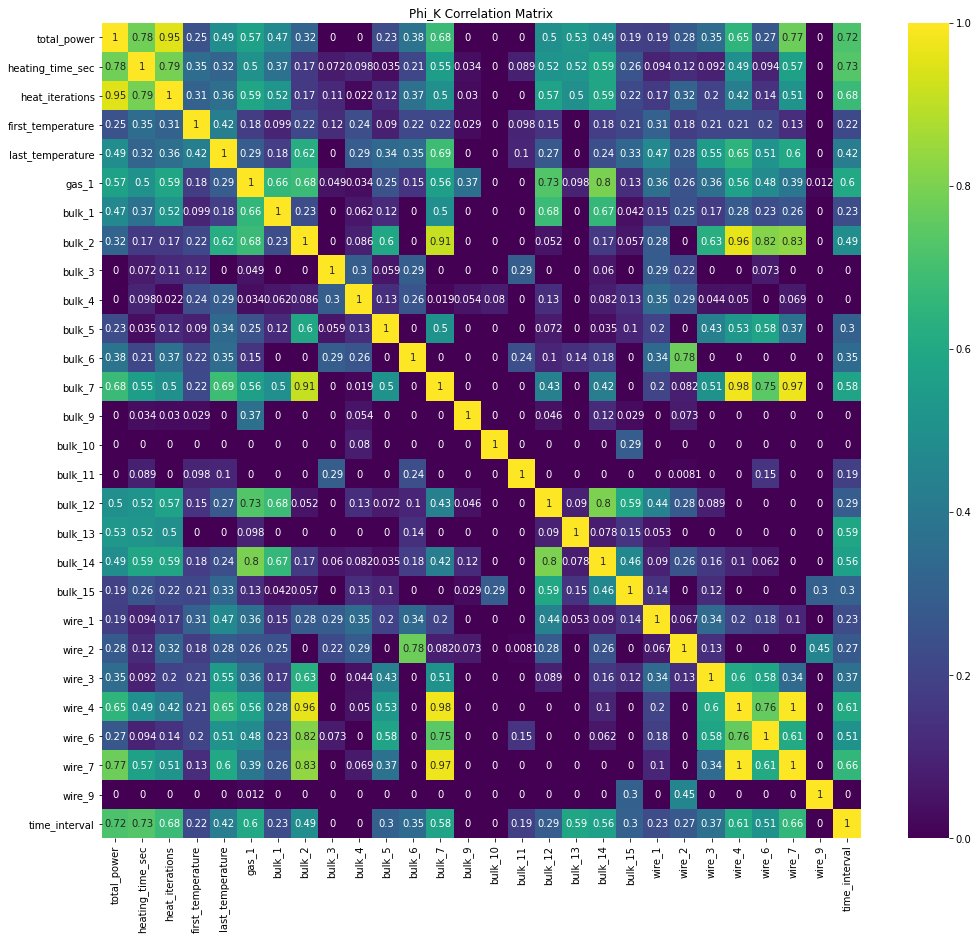

In [144]:
# Матрица корреляции Фи

fig, ax = plt.subplots(figsize=(17, 15))

sns.heatmap(df.drop(['active_power', 'reactive_power', 'wire_8', 'work'], axis=1
                   ).phik_matrix(verbose=False), annot=True, cmap='viridis')

plt.title('Phi_K Correlation Matrix');

Мультиколлинеарность лигирующих добавок. Удалим, как наименее значимые: wire_7, wire_4.

Также стоит отметить, что судя по данной таблице, на конечную температуру никак не влияют: bulk_3, bulk_09, bulk_10, bulk_13, wire_9.

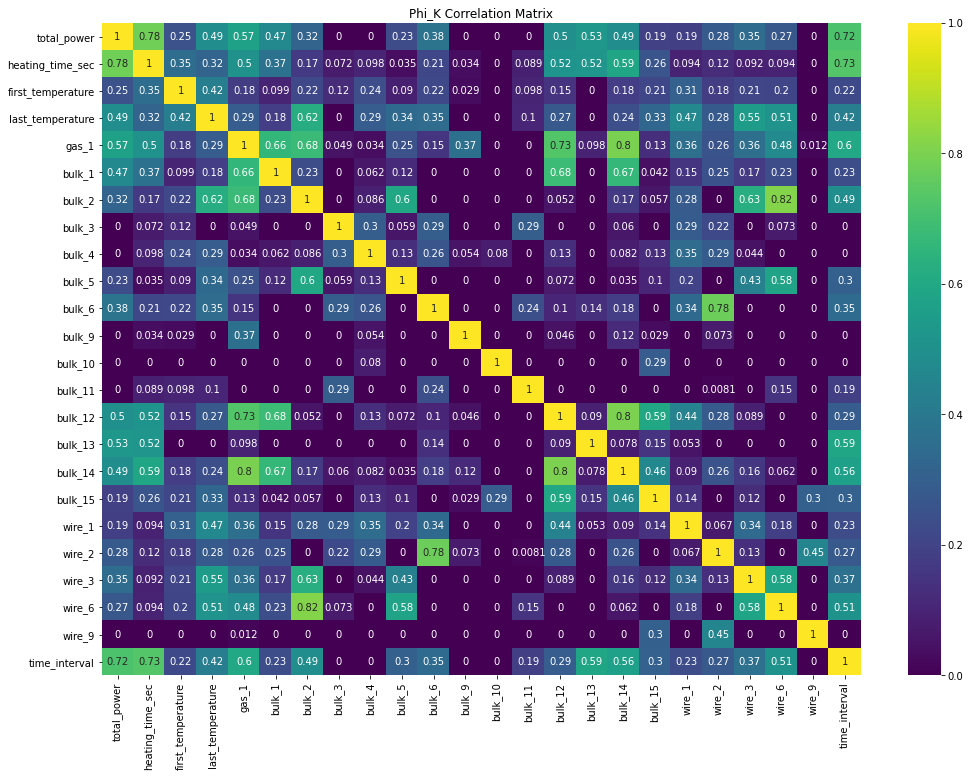

In [145]:
# Матрица корреляции Фи без wire_7, bulk_2, bulk_7

fig, ax = plt.subplots(figsize=(17, 12))

sns.heatmap(df.drop(['active_power', 'reactive_power', 'wire_8', 'work', 'wire_7', 'wire_4', 'heat_iterations', 'bulk_7'], axis=1
                   ).phik_matrix(verbose=False), annot=True, cmap='viridis')

plt.title('Phi_K Correlation Matrix');

Мультиколлинеарность (от 0.9 и выше) пропала.

Наибольшая зависимость last_temerature с признаками: wire_4, wire_3, wire_5. 
Затем: total_power, wire_1, first_temperature, time_interval.

**Вывод:**

В ходе исследовательского анализа итогового файла:
* выведены информация о файле и описание признаков
* полных дубликатов не обнаружено
* добавлены новые признаки:
  - работа
  - интервал между замерами первой и последней температур
* рассмотрены гистограммы распределения признаков: выбросы сохранены (особенности технологического процесса) 
* проведены тесты Шапиро-Уилка и Д'Агостино на нормальность распределения:
  - признаки не имют нормального распределения
* прведен корреляционный анализ признаков: Спирмана и Фи
  - удалена мультиколлинеарность
  - исключены признаки активной и реактивной мощности, добавки 'wire_8', 'wire_7', 'wire_4'

## Подготовка данных

In [146]:
# Определим целевой признак и признаки, которые нужно исключить из выборки

target = 'last_temperature'
drop_columns = ['last_temperature', 'active_power', 'reactive_power', 'wire_8', 'work', 'wire_7', 'wire_4',
                'heat_iterations', 'bulk_7'] 

In [147]:
# Разобьем файл на выборки

X = df.drop(columns=drop_columns, axis=1)
y = df[target]
    
# Для разбивки на 2 выборки

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [148]:
#Проверим размер выборок

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1746, 23) (1746,) (582, 23) (582,)


Данные отвечают условиям задачи: размер тренировочной выборки не менее 1700 строк.

Перейдем к пайплайну.

Для начала определим три типа колонок для кодировщиков: категориальные номинальные, категориальные порядковые и числовые.

In [149]:
# Посмотрим, какие числовые колонки отберет селектор:

num_code_cols = X_train.select_dtypes(include='number').columns
num_code_cols

Index(['total_power', 'heating_time_sec', 'first_temperature', 'gas_1',
       'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_9',
       'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15',
       'wire_1', 'wire_2', 'wire_3', 'wire_6', 'wire_9', 'time_interval'],
      dtype='object')

In [150]:
# Категориальные:

X_train.select_dtypes(exclude='number').columns

Index([], dtype='object')

Здесь пока пустой список, но мы оставим эти параметры пайплайна. Если в дальнейшем мы будем создавать признаки, возможно, появятся категориальные.

In [151]:
# Создадим список номинальных категориальных признаков

cat_ohe_cols = []

In [152]:
# Создадим список ранговых категориальных признаков и категории

cat_ord_cols = []
categories = [[]]

Добавляем кодирование качественных номинальных признаков спомощью OneHotEncoder. Пропуски заполняем самым частым значением с помощью SimleImputer.

In [153]:
# SimpleImputer + OHE

ohe_pipe = Pipeline([('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),\
                     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))]) 

Добавляем кодирование качественных порядковых признаков с помощью OrdinalEncoder. Пропуски до и после кодирования также заполняем самым частым значением с помощью SimleImputer.

In [154]:
# SimpleImputer + ORD + SimpleImputer
# categories : alphabetically

ord_pipe = Pipeline([('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                     ('ord', OrdinalEncoder(categories=categories,
                                            handle_unknown='use_encoded_value', unknown_value=np.nan)),
                     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))]) 

Объединим кодирование и масштабирование - ohe_pipe, ord_pipe, в пайплайн с подготовкой данных = data_preprocessor.

In [155]:
# Создаем пайплайн для обработки данных

data_preprocessor = ColumnTransformer([('ohe', ohe_pipe, cat_ohe_cols),
                                       ('ord', ord_pipe, cat_ord_cols),
                                       ('num', StandardScaler(), num_code_cols)],
                                      remainder='passthrough') 

Создадим итоговый пайплайн подготовки данных и обучения модели.

В качестве линейной модели возьмем Линейную регрессию. В качестве отправной точки.

In [156]:
# Итоговый пайплайн: подготовка данных и модель (возьмем пока что Линейную Регрессию)

pipe_final = Pipeline([('preprocessor', data_preprocessor),
                       ('models', LinearRegression())]) 

**Вывод:**

На данном этапе проведена подготовка данных для обучения моделей:
* определены уелевой и входящие признаки
* данные разбиты на тренировочную и тестовую выборки
* создан пайплайн

## Обучение моделей

Поскольку у нас непрерывный целевой признак, используем модели Регрессии.

В качестве исходной точки, рассмотрим Dummy-model

In [157]:
# Инициализируем модель и обучим ее на тренировочной выборке

dummy_model = DummyRegressor()
dummy_model.fit(X_train, y_train)

DummyRegressor()

In [158]:
# Получим предсказание на тестовых данных

dummy_model_preds = dummy_model.predict(X_test)
mae_dummy = round(mean_absolute_error(y_test, dummy_model_preds), 2)
print(f'Метрика MAE для DummyRegressor: {mae_dummy}')

r2_dummy = round(r2_score(y_test, dummy_model_preds), 2)
print(f'Метрика R2 для DummyRegressor: {r2_dummy}')


Метрика MAE для DummyRegressor: 8.09
Метрика R2 для DummyRegressor: -0.0


In [159]:
param_grid = {} # Параметры для первого обучения не задаем

pf_lr = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring = 'neg_mean_absolute_error', 
    random_state=RANDOM_STATE, 
    n_jobs=-1,
)
pf_lr.fit(X_train, y_train) 
mae_lr = round(-pf_lr.best_score_, 2)

print(f'Метрика лучшей модели при кросс-валидации: ', mae_lr)

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Метрика лучшей модели при кросс-валидации:  5.95


Метрика LinearRegression составила 5,95. По условию, нам нужно не больше 6.

In [160]:
# Сохраним тренировочную выборку с закодированными колонками

X_train_pre = pd.DataFrame(data_preprocessor.fit_transform(X_train), columns=data_preprocessor.get_feature_names_out())
X_test_pre = pd.DataFrame(data_preprocessor.transform(X_test), columns=data_preprocessor.get_feature_names_out())

In [161]:
# Рассмотрим модель Дерево решений

pipe_dt = Pipeline([('preprocessor', data_preprocessor),
                       ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))]) 

In [162]:
# Обучим модель

pipe_dt.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  []),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent'))...
                                                 ('num', StandardScaler(),
                                                  Index(['total_power', 'heating_time_sec', 'first_temperature', 'gas_1',
       'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_9',
       'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15',
       'wire_1', 'wire_2', 'wire_3', 'wire_6', 'wire_9', 'time_interval'],
      dtype='object'))])),
                ('models', DecisionTreeRegressor(random_state=200524))])

In [163]:
param_grid = {}

pf_dt = RandomizedSearchCV(
    pipe_dt, 
    param_grid, 
    cv=5,
    scoring = 'neg_mean_absolute_error', 
    random_state=RANDOM_STATE, 
    n_jobs=-1,
)
pf_dt.fit(X_train, y_train) 
mae_dt = round(-pf_dt.best_score_, 2)

print(f'Метрика лучшей модели при кросс-валидации: ', mae_dt)

Метрика лучшей модели при кросс-валидации:  8.58


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Метрика DecisionTreeRegressor 8,58.

In [164]:
# Зададим гиперпараметры пайплайна

param_distributions = [
    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()],     
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    
    # словарь для модели ElasticNet()
    {
        'models': [ElasticNet(random_state=RANDOM_STATE)],  
        'models__alpha': np.arange(0.1, 1, 0.2), 
        'models__l1_ratio': np.arange(0.1, 1, 0.2), 
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
       
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__splitter': ['best','random'],
        'models__max_depth': range(1, 45),
        'models__min_samples_leaf': range(1, 45),
        'models__max_features': range(1, 7),
        'models__min_weight_fraction_leaf':[0.1,0.2,0.3,0.4,0.5],
        'models__max_leaf_nodes':[None,10,20,30,40,50],
        'preprocessor__num': ['passthrough'] # для деревьев скаллер не нужен  
    },
        
    # словарь для модели RandomForestRegressor() 
    { 
        'models': [RandomForestRegressor(random_state=RANDOM_STATE)], 
        'models__max_depth': range(1, 5), 
        'models__min_samples_leaf': range(1, 4), 
        'models__max_features': range(1, 7), 
        'models__n_estimators': range(1, 150), 
        'preprocessor__num': ['passthrough'] # для деревьев скаллер не нужен
    }
]

In [165]:
# Зададим подбор параметров с помощью RSCV

pipe_rscv = RandomizedSearchCV(
    pipe_final, 
    param_distributions, 
    cv=5,
    scoring = 'neg_mean_absolute_error', 
    random_state=RANDOM_STATE, 
    n_jobs=-1,
)

In [166]:
# Обучим модель

pipe_rscv.fit(X_train, y_train) 

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               []),
                                                                              ('ord',
                                                                               Pipeline(steps=[('simpleImputer_before_ord',
                                                                                                Simple...
                                         'models__splitter': ['best', 'random'],
                                         'preprocessor__num': ['passthrough']},
                                        {'models': [RandomForestRegressor(random_state=200524)],
                                         'models__max_depth': range(1, 5),
                                         'models__max_features': range(1, 7),
                                         'models__min_samples_leaf': range(1, 4),
                                         'models__n_estimators': range(1, 150),
                                         'preprocessor__num': ['passthrough']}],
                   random_state=200524, scoring='neg_mean_absolute_error')

In [167]:
mae_rscv = round(-pipe_rscv.best_score_, 2)

print(f'Метрика лучшей модели при кросс-валидации: {mae_rscv}')

Метрика лучшей модели при кросс-валидации: 7.72


In [168]:
# Лучшая модель и ее параметры:

pipe_rscv.best_params_

{'preprocessor__num': 'passthrough',
 'models__splitter': 'best',
 'models__min_weight_fraction_leaf': 0.1,
 'models__min_samples_leaf': 26,
 'models__max_leaf_nodes': 10,
 'models__max_features': 5,
 'models__max_depth': 6,
 'models': DecisionTreeRegressor(random_state=200524)}

Попробуем применить градиентный бустинг

In [169]:
# Зададим гиперпараметры пайплайна

param_distributions = [
    # словарь для модели CatBoostRegressor()
    {
        'models': [CatBoostRegressor()], 
        'models__depth': range(1, 6),
        'models__learning_rate': np.arange(0.1, 0.5, 0.1),
        'models__iterations': range(50, 350, 50),
        'preprocessor__num':  [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    
    # словарь для модели LGBMRegressor()
    {
        'models': [LGBMRegressor(random_state=RANDOM_STATE, learning_rate=0.1)],  
        'models__learning_rate': np.arange(0.1, 0.5, 0.1), 
        'models__n_estimators': range(50, 350, 50), 
        'preprocessor__num':  [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },    
    
    # словарь для модели HistGradientBoostingRegressor()
    {
        'models': [HistGradientBoostingRegressor(categorical_features="from_dtype", random_state=RANDOM_STATE)],
        'models__max_depth': range(1, 6),
        'models__learning_rate': np.arange(0.1, 0.5, 0.1),
        'models__max_iter': range(50, 350, 50),
        'preprocessor__num':  [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'] 
    }
]

In [170]:
# Определим подбор параметров с помощью RSCV

pipe_boost = RandomizedSearchCV(
    pipe_final, 
    param_distributions, 
    cv=5,
    scoring = 'neg_mean_absolute_error', 
    random_state=RANDOM_STATE, 
    #n_jobs=-1,
    verbose=False
)

In [171]:
# Обучим модель

pipe_boost.fit(X_train, y_train) 

0:	learn: 10.4439409	total: 49ms	remaining: 9.75s
1:	learn: 9.9253795	total: 51.2ms	remaining: 5.07s
2:	learn: 9.5873756	total: 53ms	remaining: 3.48s
3:	learn: 9.1946409	total: 54.8ms	remaining: 2.69s
4:	learn: 9.0081905	total: 56.6ms	remaining: 2.21s
5:	learn: 8.6817095	total: 58.4ms	remaining: 1.89s
6:	learn: 8.5145490	total: 60.4ms	remaining: 1.67s
7:	learn: 8.4231555	total: 62.3ms	remaining: 1.5s
8:	learn: 8.2785420	total: 64.2ms	remaining: 1.36s
9:	learn: 8.1916142	total: 66ms	remaining: 1.25s
10:	learn: 8.0739494	total: 67.8ms	remaining: 1.16s
11:	learn: 7.9827244	total: 69.5ms	remaining: 1.09s
12:	learn: 7.8889562	total: 71.7ms	remaining: 1.03s
13:	learn: 7.8117962	total: 73.4ms	remaining: 976ms
14:	learn: 7.6962745	total: 75.3ms	remaining: 929ms
15:	learn: 7.6377645	total: 77ms	remaining: 886ms
16:	learn: 7.5546538	total: 78.9ms	remaining: 850ms
17:	learn: 7.4911052	total: 80.7ms	remaining: 816ms
18:	learn: 7.3915561	total: 82.7ms	remaining: 788ms
19:	learn: 7.3439749	total: 84

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               []),
                                                                              ('ord',
                                                                               Pipeline(steps=[('simpleImputer_before_ord',
                                                                                                Simple...
                                        {'models': [HistGradientBoostingRegressor(categorical_features='from_dtype',
                                                                                  random_state=200524)],
                                         'models__learning_rate': array([0.1, 0.2, 0.3, 0.4]),
                                         'models__max_depth': range(1, 6),
                                         'models__max_iter': range(50, 350, 50),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler(),
                                                               'passthrough']}],
                   random_state=200524, scoring='neg_mean_absolute_error',
                   verbose=False)

In [172]:
mae_boost = round(-pipe_boost.best_score_, 2)

print(f'Метрика лучшей модели при кросс-валидации: {mae_boost}')

Метрика лучшей модели при кросс-валидации: 5.86


In [173]:
# Лучшая модель и ее параметры:

pipe_boost.best_params_

{'preprocessor__num': MinMaxScaler(),
 'models__learning_rate': 0.30000000000000004,
 'models__iterations': 100,
 'models__depth': 3,
 'models': <catboost.core.CatBoostRegressor at 0x7f9b05ec72b0>}

**Вывод:**

В качестве отправной точки рассмотрена модель DummyRegressor. Ее метрика MAE = 8.08, R2 = 0.0, т.е модель показывает крайне низкие результаты.

С использованием пайплайна и подбора гиперпараметров обучены модели:
* LinearRegression
* DecisionTreeRegressor
* ElasticNet
* RandomForestRegressor
* CatBoostRegressor
* LGBMRegressor
* HistGradientBoostingRegressor

## Выбор лучшей модели

In [174]:
#Соберем итоги

model_comparison = pd.DataFrame({'model_type': ['DummyRegressor', 'LinearRegression', 'DecisionTreeRegressor', 'DecisionTreeRegressor (param)',
                                               'HistGradientBoostingRegressor (param)'],
                                 'mae_train': [mae_dummy, mae_lr, mae_dt, mae_rscv, mae_boost],
                                 'models': [dummy_model , pf_lr.best_estimator_[1], pf_dt.best_estimator_[1], pipe_rscv.best_estimator_[1],
                                            pipe_boost.best_estimator_[1]]
                                })

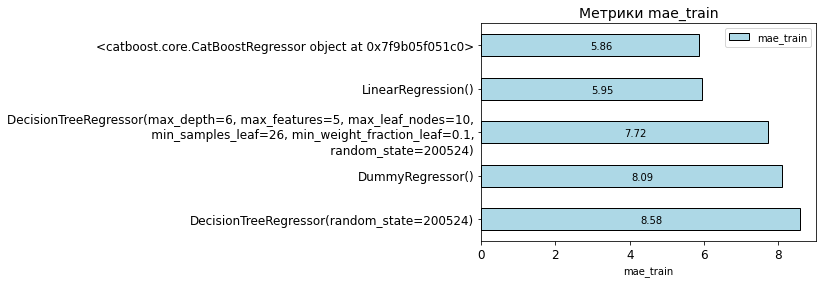

In [175]:
# Визуализация

model_comparison.sort_values('mae_train', ascending=False
                            ).plot(x='models', y='mae_train', kind='barh', color='LightBlue', edgecolor='black');
x_axes = list(model_comparison.mae_train.sort_values(ascending=False))
for i, item in enumerate(x_axes):
    plt.text(item - item/2, i - 0.1, str(item), color='black')
    
plt.ylabel(''); plt.yticks(size = 12); plt.xlabel('mae_train'); plt.xticks(size = 12);
plt.title('Метрики mae_train', size = 14);

Таким образом, лучшей моделью является:

{'preprocessor__num': MinMaxScaler(),
 'models__learning_rate': 0.30000000000000004,
 'models__iterations': 100,
 'models__depth': 3,
 'models': <catboost.core.CatBoostRegressor at 0x7ff0f917bf10>}

Лучшая метрика составляет: 5.86

In [176]:
# Рассчитаем метрику на тестовой выборке

y_pred_boost = pipe_boost.best_estimator_.predict(X_test)
mae_test = round(mean_absolute_error(y_test, y_pred_boost), 2)
print(f'Метрика MAE на тестовой выборке: {mae_test}')

Метрика MAE на тестовой выборке: 5.97


Метрика MAE на тестовой выборке: 5.97

Т.о. отобранная модель предсказывает целевой признак с отклонением 6.08 градуса. Метрика устойчива к выбросам, что оптимально подходит к нашей задаче. Поскольку в наблюдениях мы видим разные варианты сочетаний параметров для отдельных плавок, в т.ч. с большими колебаниями значений (выбросами).

In [177]:
# Рассчитаем r2 на тестовых данных

r2_test = round(r2_score(y_test, y_pred_boost), 2)
print(f'Метрика R2 на тестовой выборке: {r2_test}')

Метрика R2 на тестовой выборке: 0.47


Метрика R2 на тестовой выборке: 0.47

Значение R2 не очень велико, т.е. модель ошибается примерно в половине случаев.
Также это может свидетельствовать о большой вариативности связи между признаками и таргетом (что как раз отражает наш случай). Следует знать средние показатели R2 в данной области, а также приемлемые для данной конкретной компании значения, чтобы оценить, насколь эта величина "хороша" или "плоха".

В целом, метрика R2 отражает способность модели к обобщению и предсказанию целевого признака по входным. Положительные значения R2 показывают, в скольких процентах случаев предсказание модели ближе к истине, чем среднее значение целевого признака. Отрицательный R2 означает, что средние значения всегда лучше прогнозных (наш вариант с DummyRegressor). 

## Анализ важности признаков

In [178]:
# Сохраним тренировочную выборку с закодированными колонками

X_train_pre = pd.DataFrame(data_preprocessor.fit_transform(X_train), columns=data_preprocessor.get_feature_names_out())
X_test_pre = pd.DataFrame(data_preprocessor.transform(X_test), columns=data_preprocessor.get_feature_names_out())

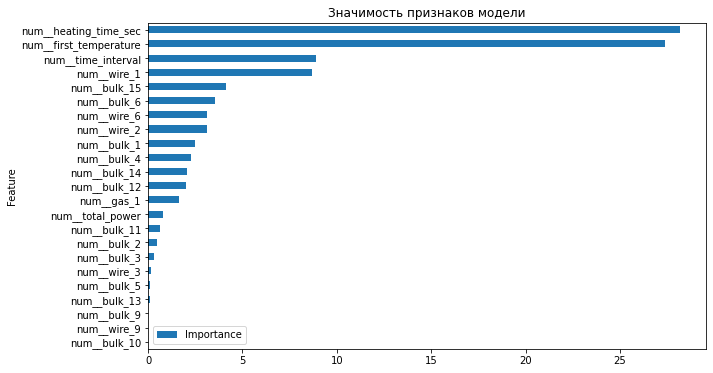

In [179]:
# Посмотрим на значимость признаков модели на графике

feature_importance = pd.DataFrame({'Feature': X_train_pre.columns, 'Importance': 
                                   np.abs(pipe_boost.best_estimator_._final_estimator.feature_importances_)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))
plt.title("Значимость признаков модели");

In [180]:
# Определим наименее важные признаки (значимость меньше 0,05)

features_to_drop = feature_importance[feature_importance['Importance'] < 0.05]['Feature'].to_list() 
features_to_drop

['num__bulk_10', 'num__wire_9', 'num__bulk_9']

In [181]:
# Удалим их из тренировочной и тестовой выборок

X_train_less_features = X_train_pre.drop(features_to_drop, axis=1)
X_test_less_features = X_test_pre.drop(features_to_drop, axis=1)

In [182]:
# Определим модель, как лучший вариант из рассмотренных

cat_less_features = pipe_boost.best_estimator_._final_estimator

In [183]:
# Обучим модель на данных, за вычетом наименее важных признаков

cat_less_features.fit(X_train_less_features, y_train)

0:	learn: 10.5768866	total: 998us	remaining: 98.9ms
1:	learn: 10.2638464	total: 2.15ms	remaining: 106ms
2:	learn: 10.0129831	total: 3.1ms	remaining: 100ms
3:	learn: 9.7037711	total: 3.98ms	remaining: 95.5ms
4:	learn: 9.4263520	total: 4.91ms	remaining: 93.4ms
5:	learn: 9.2652577	total: 5.83ms	remaining: 91.4ms
6:	learn: 9.1466883	total: 6.67ms	remaining: 88.7ms
7:	learn: 9.0281905	total: 7.58ms	remaining: 87.1ms
8:	learn: 8.8881073	total: 8.58ms	remaining: 86.7ms
9:	learn: 8.7212652	total: 9.49ms	remaining: 85.4ms
10:	learn: 8.5890428	total: 10.4ms	remaining: 84.3ms
11:	learn: 8.4740323	total: 11.3ms	remaining: 82.9ms
12:	learn: 8.3846615	total: 12.2ms	remaining: 81.7ms
13:	learn: 8.3502019	total: 13.1ms	remaining: 80.7ms
14:	learn: 8.3093437	total: 14.1ms	remaining: 79.8ms
15:	learn: 8.2454049	total: 15ms	remaining: 78.9ms
16:	learn: 8.1866971	total: 15.9ms	remaining: 77.5ms
17:	learn: 8.1101158	total: 16.8ms	remaining: 76.4ms
18:	learn: 8.0423104	total: 17.7ms	remaining: 75.4ms
19:	le

In [184]:
# Получим предсказание модели для тестовой выборки

y_less_features_pred = cat_less_features.predict(X_test_less_features)

mae_cat = round(mean_absolute_error(y_test, y_less_features_pred), 2)
print(f'Метрика на тестовой выборке с меньшим числом признаков: {mae_cat}')

r2_cat = round(r2_score(y_test, y_less_features_pred), 2)
print(f'Метрика R2 для cat_less_features: {r2_cat}')


Метрика на тестовой выборке с меньшим числом признаков: 6.12
Метрика R2 для cat_less_features: 0.47


Метрика на тестовой выборке с меньшим числом признаков: 6.12

Метрика R2 для cat_less_features: 0.47

Т.е. удаление наиболее редких признаков (до 5% значимости) несколько ухудшило метрику. 
При этом ( в предыдущей итерации это првоерено) , если удалить признаки значимостью до 10% (сюда добавляется bulk_5), метрики ухудшаются.
Скорее всего добавки важны, поэтому просто так по объему пропусков удалять их не стоит.

Рассмотрим значимость признаков с помощью SHAP

In [185]:
explainer = shap.TreeExplainer(cat_less_features, X_test_less_features)
shap_values = explainer(X_test_less_features)

(тут какая-то непонятная ошибка вылезает. не нашла, в чем причина)

shap.plots.bar(shap_values) 

Здесь график не отобразился корректно, но тем не менее 3 основные признака очень хорошо отстоят от остальных:
* время нагрева
* начальная температура
* интервал между измерениями температур

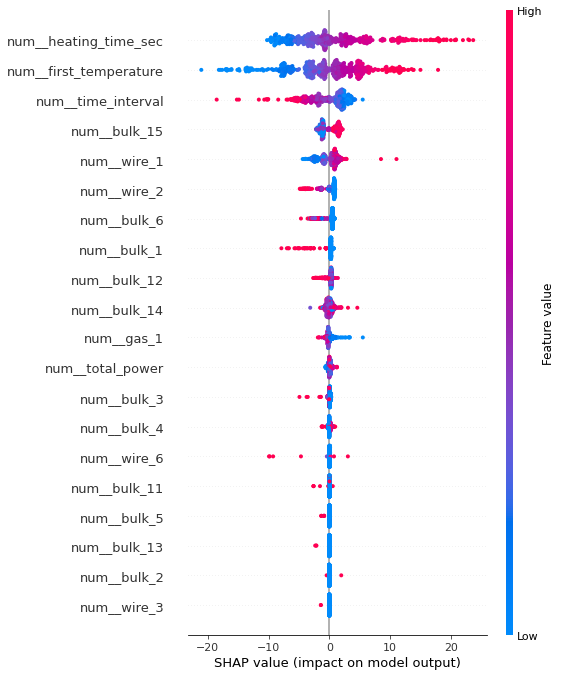

In [186]:
shap_test = shap.TreeExplainer(cat_less_features).shap_values(X_test_less_features)
shap.summary_plot(shap_test, X_test_less_features, 
                  #max_display=25, 
                  auto_size_plot=True)

Что можно сказать о признаках, судя по графику:
* ключевой параметр - это время нагрева, чем он выше, тем выше конечная температура сплава
* чем выше начальная температура, тем выше конечная
* чем короче интервал между измерениями температур, тем конечная температура выше

Ключевые признаки - это первые 4 строки:
* время нагрева
* начальная температура
* интервал между измерениями температур
* wire_1
* распространенность остальных признаков намного ниже

Далее идет влияние лигирующих добавок:
* в большей степени повышает конечную температуру wire_1
* bulk_6 понижает конечную температуру сплава
* bulk_15, bulk_12, bulk_4, bulk_14 повышают конечную температуру
* высокие значения wire_2, bulk_1, bulk_11, bulk_3, wire_6, wire_3 и продувка газом понижают конечную температуру

Можно посмотреть, как именно признаки повлияли на предсказание конкретного значения.

In [187]:
y_less_features_pred[0]

1585.7342190399747

In [188]:
y_test.head(1)

2251   1586.000
Name: last_temperature, dtype: float64

In [189]:
X_test_less_features.head(1)

,num__total_power,num__heating_time_sec,num__first_temperature,num__gas_1,num__bulk_1,num__bulk_2,num__bulk_3,num__bulk_4,num__bulk_5,num__bulk_6,num__bulk_11,num__bulk_12,num__bulk_13,num__bulk_14,num__bulk_15,num__wire_1,num__wire_2,num__wire_3,num__wire_6,num__time_interval
0,-1.192,-0.573,-0.790,-0.913,-0.282,-0.079,0.731,-0.640,-0.116,-0.409,-0.189,0.130,-0.076,-0.477,-0.147,-1.276,-0.533,-0.120,-0.112,-0.889


In [190]:
X_test.head(1)

,total_power,heating_time_sec,first_temperature,gas_1,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_6,wire_9,time_interval
2251,2.046,607,1569.000,5.444,0.000,0.000,104.000,0.000,0.000,0.000,0.000,0.000,0.000,226.000,0.000,114.000,106.000,47.087,0.000,0.000,0.000,0.000,1060


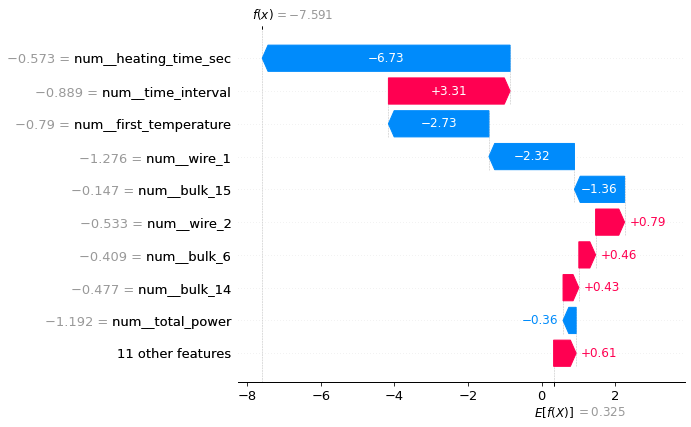

In [191]:
# График для данного наблюдения:

shap.plots.waterfall(shap_values[0]) 

Небольшое вермя нагрева сыграло ключевую роль в понижении конечной температуры, плюс влияние продувки газом и низкая исходная температура. Добавление wire_1, bulk_4, bulk_1, bulk_15 повысило температуру. Тажке несколько повысили конечную температуру добавки wire_2, bulk_12 и прочие факторы.

**Вывод:**

Анализ важности признаков выявил наиболее значимые параметры для предсказаний модели: 
* время нагрева
* начальная температура
* интервал между измерениями температур

Наименее значимыми (влияние меньше 5%) оказались:
* wire_8, bulk_9, bulk_13, wire_9 (они были удалены для оптимизации модели)

Однако при удалении большего числа признаков (при влиянии до 10%) модель показала ухудшение метрик.

Т.о. в данной задаче не стоит полагаться только на количественные показатели. Необходимо знать особенности влияния различных лигирующих добавок на параметры плавки и температуру, особенности технологического процесса.

Наиболее значимо на конечную температуру воздействует wire_1.
Стоит также отметить, что:
* bulk_6 понижает конечную температуру сплава
* bulk_15, bulk_12, bulk_4, bulk_14 повышают конечную температуру
* высокие значения wire_2, bulk_1, bulk_11, bulk_3, wire_6, wire_3 и продувка газом понижают конечную температуру

## Общий вывод и рекомендации заказчику

В исходных данных выявлено большое количество пропусков в целевом признаке. Заказчику стоит обратить на это внимание и оптимизировать сбор данных.

Пропуски в группах лигирующих добавок отражают особенности данной задачи и технологический процесс.

В ходе исследовательского анализа данных были обнаружены аномальные значения в признаке температура (меньше 1500 градусов) и едничная отрицательная реактивная мощность. Аномальный отрицательный показатель реактивной мощности заменен на долю активной мощности среднюю по данной плавке. Пропуски и аномалии температуры удалены. Также удалены плавки с единичным показателем температуры.

В данных нет дубликатов. Пропуски в лигирующих добавках заменены на нули.

Определены группы лигирующих добавок с числом пропусков больше 80% :
* bulk_1 , bulk_2 , bulk_5 , bulk_6 , bulk_7 , bulk_9 , bulk_10 , bulk_11, bulk_13
  bulk_8 - единичное применение за весь период наблюдений
* wire_3, wire_4, wire_6, wire_7, wire_8, wire_9 
  wire_5 - единичное применение за весь период наблюдений
Это могут быть, как редко применяемые добавки из-за особенностей стали, так и пробные партии для испытаний, или аналоги более дорогих материалов. Добавки с единичным применением были удалены.

Анализ гистограмм, а также тесты Шапиро-Уилка и Д'Агостини показывают, что данные не имеют нормального распределения и содержат выбросы. Однако удалять их не следует, т.к. это связано с разными видами плавок и особенностями технологического процесса (разное количество и время засыпки лигирующих добавок, разные температуры и время нагрева, число итераций нагрева и т.д.)

Вместе с объединением данных в общий файл были созданы дополнительные признаки: 
  - общая мощность
  - время нагрева
  - число итераций нагрева
  - первая температура
  - последняя температура
  - суммарный объем лигирующих добавок (по видам)
  - работа
  - интервал между замерами первой и последней температур
  
Общий файл сохранил выбросы в признаках.
Матрица корреляции показала мультиколлинеарность, чтобы ее избежать, были удалены следующие признаки: активная и реактивная мощности, добавки 'wire_8', 'wire_7', 'wire_4'.

Для обучения моделей и подбора параметров был использован пайплайн.
В качестве отправной точки рассмотрена модель DummyRegressor. Ее метрика MAE = 8.17, R2 = 0.0, т.е модель показывает крайне низкие результаты.

С использованием пайплайна и подбора гиперпараметров обучены модели:
* LinearRegression
* DecisionTreeRegressor
* ElasticNet
* RandomForestRegressor
* CatBoostRegressor
* LGBMRegressor
* HistGradientBoostingRegressor

На основе сравнения метрики MAE, была определена лучшая модель:

{'preprocessor__num': RobustScaler(),
 'models__learning_rate': 0.1,
 'models__iterations': 200,
 'models__depth': 3,
 'models': <catboost.core.CatBoostRegressor at 0x7f46efaa34c0>}
 
Лучшая метрика на тестовой выборке составляет: 5.86
Метрика MAE на тестовой выборке: 5.81

По условию задачи для лучшей модели рассчитана метрика R2.

Метрика R2 на тестовой выборке: 0.52

Это означает, что точность предсказаний модели составляет 52% случаев. Однако следует учитывать, что метрика R2 показывает не очень высокие результаты на выборках с большим числом выбросов и разбросом данных. Наш случай именно такой. Поэтому не следует ориентироваться только на число R2 по данной модели. Следует знать средние показатели R2 в целом по отрасли, а также определить приемлемые значения метрики именно для данного предприятия.

Анализ важности признаков показал интересную особенность. Удаление наименее значимых 5% признаков улучшило метрику MAE до 5.79.
Однако при удалении 10% малозначимых признаков, метрика MAE стала хуже. Т.о. не следует полагаться только на количественные покзатели. В данном случае следует хорошо понимать осоебенности технологического процесса и особенности влияния на конечную температуру отдельных видов лигирующих добавок. А оно может как повышать конечную температуру сплава (Наиболее значимо: wire_1, с мениших масштабах: bulk_15, bulk_12, bulk_4, bulk_14), так и понижать ее (наиболее значимо: bulk_6, в меньшей степени: wire_2, bulk_1, bulk_11, bulk_3, wire_6, wire_3 и продувка газом).

Наиболее существенно определяют конечную тепературу:
* время нагрева
* начальная температура
* интервал между измерениями температур